### Libraries Required

In [305]:
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from tqdm import tqdm as tq
from collections import Counter
import math
import numpy as np
import csv
import random
import itertools
import heapq
from heapq import *
import warnings
import geocoder
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'
import requests
import bs4
import lxml
import re
from tqdm import tqdm as tq
from time import sleep
from random import randint
from datetime import datetime
import pandas as pd
import pathlib
import urllib
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib import pyplot as plt


### Setting  Seed

In [306]:
##Setting sedd to get deterministic hash Id's for vocabulary and inverted_index
PYTHONHASHSEED=12345

## Q1 Data collection

### Getting URL's of the 7200 places from 400 pages of Atlasobscura webpage

> #### Created a History_url list variable to stores the url of the 7200 places.
> #### To obatin the url of the places of an given page, I use requests and beautiful soup library to obtain and parse the html code of the page.
> #### Each page presents information of the 18 places and hence to get the url of the places I use a-tag with specific class-type and retrived h-ref attribute to get the links and store it in history_url.


In [307]:
history_url=[]  ##Store Url's of the webpage

count=0  ## To have a check of the number of links extracted from the 400 pages of the platform

for i in tq(range(1,401)):
    
    ### Using i as an variable to request webpage data of different of places from first 400 pages of the platfrom
    results=requests.get('https://www.atlasobscura.com/places?page='+str(i)+'&sort=likes_count')
    
    ### Beautiful Soup to parse the Html code of an given webpage
    soup=bs4.BeautifulSoup(results.text)
    
    ### Getting Links of the places present in the webpage.
    urls=[item.get('href') for item in soup.find_all('a') if item.get('class')== ['content-card','content-card-place'] ]
    
    count += len(urls)
    
    history_url=history_url+urls


### Storing Scrapped URL's of the places 

> ### To avoid repeated requested for the same. 

In [308]:
# x=pd.DataFrame({'A':history_url}) ### Creating a dataframe of the URl's scrapped from the 400 webpages of the places

# x.to_csv('url.csv')  ### Exporting to CSV

history_url=list(pd.read_csv('url.csv')['A'].values) ### Reading stored url's
history_url

['/places/city-hall-station',
 '/places/highgate-cemetery',
 '/places/leadenhall-market',
 '/places/wave-organ',
 '/places/catacombes-de-paris',
 '/places/evolution-store',
 '/places/magowans-infinite-mirror-maze',
 '/places/underground-tunnels-los-angeles',
 '/places/secret-tiled-staircase',
 '/places/dream-house',
 '/places/the-museum-of-death-los-angeles-california',
 '/places/last-bookstore',
 '/places/gods-own-junkyard',
 '/places/echo-park-time-travel-mart',
 '/places/the-ruins-of-st-dunstan-in-the-east-london-england',
 '/places/fingal-s-cave',
 '/places/wave-rock',
 '/places/winchester-mystery-house',
 '/places/roosevelt-island-smallpox-hospital-ruins',
 '/places/eastern-state-penitentiary',
 '/places/mutter-museum',
 '/places/fly-ranch-geyser',
 '/places/antelope-canyon',
 '/places/the-elevated-acre-new-york-new-york',
 '/places/thor-s-well',
 '/places/seward-street-slides',
 '/places/mmuseumm-2',
 '/places/ghibli-museum',
 '/places/spreepark',
 '/places/twinings-tea-shop',
 '

### Function to store Html files of the Individual Pages

In [242]:
def store_html(results,i,file):

    new_dir=pathlib.Path('D:/Anaconda/my-work/ADM/','place_html_1/place'+str(i)) 
    new_dir.mkdir(parents=True, exist_ok=True)
    # You have to make a file inside the new directory
    y=file+'.html'
    new_file = new_dir / y
    f=open(new_file,'wb')
    
    f.write(results.content)
    f.close()

### Function to get variable of interest:
> #### This function accepts the URL of the various places. Using requests function we get the html code of the webpage.
> #### Then the HTML code of a place is stored in it's specific folder based on the webpage page number(sorted with number of likes)
> #### Then using the Beautiful Soup(bs4) package we extract the information of the variables of interest.


In [4]:
def extract_single_place(url,index,file_name):
        """
        The extract_single_place function extracts the variables of interest information from the webpage and returns a dictionary of
        those features for that place.

        : url: str, the url of the place of which we want to extract the information
        : index: int, The page number of the place at which it was showcased.
        :file_name:str,It is the title of the place which would be used to save it's .html place 
        : place_information:dict,The dictionary of extracted features.

        """ 
        results=requests.get(url)
        store_html(results,index,file_name)
        soup=bs4.BeautifulSoup(results.text)
        place_information={}
        ###Find Title###
        try:
            for item in soup.find_all('h1'): 
                if item.get('class')==['DDPage__header-title']:

                        place_information['placeName']=str(item.get_text(strip=True,separator=' '))
        except:
                    place_information['placeName']=''
        ### Find Location(Tags):
        try:
            Tag =soup.find('div',{'class':"DDPage__header-place-location"}).get_text(strip=True,separator=' ')
            place_information['placeTags']=Tag
        except:
            place_information['placeTags']=''
        ### Find Number of people visited
        try:
            number_of_people_visited=soup.find('div',{'col-xs-4X js-submit-wrap js-been-to-top-wrap action-btn-col hidden-print'}).get_text(strip=True,separator=' ')
            place_information['numPeopleVisited']=int(re.search('\d+',number_of_people_visited).group())
        except:
            place_information['numPeopleVisited']=''

        ### Find Number of People who want to go
        try:
            people_want_go=soup.find('div',{'col-xs-4X js-submit-wrap js-like-top-wrap action-btn-col hidden-print'}).get_text(strip=True,separator=' ')
            place_information['numPeopleWant']=int(re.search('\d+',people_want_go).group())
        except:
            place_information['numPeopleWant']=''

        #### Place description
        try:
            places_des=soup.find('div',{'class':['DDP__body-copy']}).get_text(strip=True,separator=' ')
            place_information['placeDesc']=str(places_des)
        except:
            place_information['placeDesc']=''
        ### Short description:
        try:
            title1=soup.find('h1',{'class':['DDPage__header-title']}).get_text(strip=True,separator=' ')
            Tag =soup.find('div',{'class':"DDPage__header-place-location"}).get_text(strip=True,separator=' ')
            short_des=soup.find('h3',{'class':['DDPage__header-dek']}).get_text(strip=True,separator=' ')
            place_information['placeShortDesc']=str(title1)+','+str(Tag)+', '+str(short_des) ###Seperate by commas
        except:
            place_information['placeShortDesc']=''

        ### Nearby places
        try:
            places=[]
            for items in soup.find_all('div',{'class':['DDPageSiderailRecirc__item-title']}):
                places.append(items.get_text(strip=True,separator=' '))
            place_information['placeNearby']=list(set(places))
        except:
            place_information['placeNearby']=''

        ### Place Address:
        try:
            items=soup.find('address',{'class':['DDPageSiderail__address']})
            x=items.find('div',attrs={'class':None}) 
            ## Check the example for some idea of it's functioning
            y=x.get_text(strip=True,separator=' ')
            z=x.find('div').get_text(strip=True,separator=' ')
            place_information['placeAddress']=y.rsplit(z)[0]
        except:
            place_information['placeAddress']=''    
        ### Place Altitude and Latitude
        try:
            items=soup.find('div',{'class':['DDPageSiderail__coordinates js-copy-coordinates']})
            cord=items.get_text(strip=True,separator=' ').rsplit(',')
            place_information['placeAlt']=float(cord[0])   #### FLoat or integers????
            place_information['placeLong']=float(cord[1])   
        except:
            place_information['placeAlt']=''  #### FLoat or integers????
            place_information['placeLong']=''   

        #### Post editors:
        try:
            editors=[]
            for items in soup.find_all('li',{'class':["DDPContributorsList__item"]}):
                editors.append(items.find('span').get_text(strip=True,separator=' '))

            place_information['placeEditors']=editors
            if len(editors)==0:
                for items in soup.find_all('div',{'class':["DDPContributorsList"]}):
                    editors.append(items.get_text(strip=True,separator=' ').split(','))
                editors=editors[-1]
                place_information['placeEditors']=editors

        except:
            place_information['placeEditors']=''

        ###Post publishing date
        try:
            items=soup.find('div',{'class':["DDPContributor__name"]})
            date=items.get_text(strip=True,separator='')
            #date_time_obj = datetime.strptime(date, '%b %d, %Y')
            place_information['placePubDate']=date     
        except:
            place_information['placePubDate']=''
        ### Finding related places
        try:
            var=[]
            for items in soup.find_all('div',{'class':["card-grid CardRecircSection__card-grid js-inject-gtm-data-in-child-links"]}):
                var.append(items.find_all('h3',{'class':["Card__heading --content-card-v2-title js-title-content"]}))
            Related_places=[]
            for j in var[1]:
                    Related_places.append(j.find('span').get_text(strip=True,separator=' '))
            place_information['placeRelatedPlaces']=Related_places
        except:
            place_information['placeRelatedPlaces']=''

        ### Finding Appeared list
        try:
            var=[]
            for items in soup.find_all('div',{'class':["card-grid CardRecircSection__card-grid js-inject-gtm-data-in-child-links"]}):
                var.append(items.find_all('h3',{'class':["Card__heading --content-card-v2-title js-title-content"]}))
            Appeared_list=[]
            for j in var[2]:
                    Appeared_list.append(j.find('span').get_text(strip=True,separator=' '))
            place_information['placeRelatedLists']=Appeared_list
        except:
            place_information['placeRelatedLists']=''

        ### URL
        place_information['placeURL']=url
        
        return place_information

### Extract 7200 places information

> #### Based on the url's of all the places extracted previously and stored in history_url,we extract features of interest for places.
> #### To avoid getting blocked from the webpage,we use sleep function to put some time between two requests.
> #### All the dictionaries of the places are stored in the list_dict variable.

In [249]:
list_dict=[] ### Store places information
for i,j in tq(enumerate(history_url)):
 
 index=(i)//18 + 1 ### Gives the page number that place belongs too

 z=re.findall('\/\w+\/(.*)',history_url[i])  ### extract the place tittle from the place url
 
 sleep(randint(1,3)) ### Creating time difference between requests.

 list_dict.append(extract_single_place('https://www.atlasobscura.com'+history_url[i],index,z[0]))

In [250]:

list_dict

100%|██████████████████████████████████████████████████████████████████████████████| 7200/7200 [37:02<00:00,  3.24it/s]


[{'placeName': 'City Hall Station',
  'placeTags': 'Manhattan, New York',
  'numPeopleVisited': 1824,
  'numPeopleWant': 8569,
  'placeDesc': 'The first New York City subway was built and operated by the Interborough Rapid Transit Company (IRT) and opened on October 27, 1904, to the joy of New York elevated train and streetcar riders. The City Hall station on the IRT local track was lavished with fine architectural details, including glass tiles and large chandeliers. However, the Gustavino vaulted ceilings and skylights were lost on busy commuters, and the stop was one of the least-used in the system. It was the only station that did not have turnstiles installed by 1923, and the nearby Brooklyn Bridge stop was frequented by the express train and closer to connecting streetcars. Because of the curved platform, cars with center doors could not be used at this station unless they had specially modified door controls which allowed just the end doors to be opened. In 1945, the station was

### Converting the list containing the each place dictionary to Pandas DatFrame

In [251]:
x=pd.DataFrame(columns=['placeName','placeTags','numPeopleVisited','numPeopleWant','placeDesc','placeShortDesc','placeNearby','placeAddress','placeAlt','placeLong','placeEditors','placePubDate','placeRelatedLists','placeRelatedPlaces','placeURL'])
for i,j in tq(enumerate(list_dict)):
    for k in j.keys():
        x.at[i,k]=j[k]

x

7200it [00:10, 685.69it/s] 


placeName                    placeTags numPeopleVisited  \
0            City Hall Station          Manhattan, New York             1824   
1            Highgate Cemetery              London, England             2615   
2            Leadenhall Market              London, England             3133   
3               The Wave Organ    San Francisco, California             2426   
4          Catacombes de Paris                Paris, France             4442   
...                        ...                          ...              ...   
7195          Xul Solar Museum      Buenos Aires, Argentina              129   
7196  Klatovy Catacomb Mummies             Klatovy, Czechia               49   
7197       Termesphere Gallery      Spearfish, South Dakota               71   
7198              Wheeler Peak  Taos Ski Valley, New Mexico              241   
7199                     Olana             Hudson, New York              357   

     numPeopleWant                                          placeDesc  \
0             8569  The first New York City subway was built and o...   
1             8179  Opened in 1839, Highgate is one of London’s mo...   
2             7560  The ornate 19th-century painted roof and cobbl...   
3             7400  Located on a jetty in the San Francisco Bay, t...   
4             7036  In 2004, Parisian police were assigned to do a...   
...            ...                                                ...   
7195           405  With dreams of reforming and perfecting the un...   
7196           405  In an underground crypt beneath a Jesuit churc...   
7197           405  Most artists paint on a a flat plane, but in t...   
7198           405  At least six mountains in the southwestern Uni...   
7199           405  The Hudson River School of painters popularize...   

                                         placeShortDesc  \
0     City Hall Station,Manhattan, New York, A beaut...   
1     Highgate Cemetery,London, England, London's cr...   
2     Leadenhall Market,London, England, This ornate...   
3     The Wave Organ,San Francisco, California, A hu...   
4     Catacombes de Paris,Paris, France, The vast, l...   
...                                                 ...   
7195  Xul Solar Museum,Buenos Aires, Argentina, Xul ...   
7196  Klatovy Catacomb Mummies,Klatovy, Czechia, The...   
7197  Termesphere Gallery,Spearfish, South Dakota, T...   
7198  Wheeler Peak,Taos Ski Valley, New Mexico, This...   
7199  Olana,Hudson, New York, The Hudson River Schoo...   

                                            placeNearby  \
0     [The Sugar House Prison Window, African Burial...   
1     [Dick Whittington’s Cat, World's Largest Potte...   
2     [Philpot Lane Mice Sculpture, London's Origina...   
3     [Palace of Fine Arts, Long Now Orrery, The Ste...   
4     [Arago Medallions, Jeannot's Floor, Sculptures...   
...                                                 ...   
7195  [Villa Freud, Ricardo Rojas House Museum, El A...   
7196  [Entropa, Drachenstich-Festspiele, Poledník Lo...   
7197  [Fish Car No. 3, Mt. Moriah Cemetery, Mount Ro...   
7198  [Ski-Slope Tree Martinis, El Salto del Agua Wa...   
7199  [Catskill Game Farm, Basement Bistro, Hudson-A...   

                                           placeAddress placeAlt placeLong  \
0     31 Centre St New York, New York, 10007 United ...  40.7134  -74.0046   
1     Swain's Lane, Highgate London, England, N6 Uni...  51.5675   -0.1483   
2                 London, England, EC3V United Kingdom   51.5126   -0.0834   
3     83 Marina Green Dr San Francisco, California, ...  37.8085 -122.4401   
4        1 Place Denfert-Rochereau Paris, 75014 France   48.8343    2.3322   
...                                                 ...      ...       ...   
7195               Laprida 1212 Buenos Aires Argentina  -34.5948  -58.4078   
7196                          Denisova Klatovy Czechia   49.3951   13.2918   
7197  1920 Christensen Drive Spearfish, South Dakota...  44.457

### Saving Pandas DataFrame

In [5]:
x.to_csv('Full_Dataset_Cleaned-v2.csv',encoding='utf-8-sig')

## Q2  Search Engine

### Reading the Scrapped Features of the 7200 Webpages stored in DataFrame

In [309]:
data=pd.read_csv('Full_Dataset_Cleaned-v2.csv') ## reading dataset
data=data.drop('Unnamed: 0',axis=1)
data

placeName                    placeTags  numPeopleVisited  \
0            City Hall Station          Manhattan, New York              1824   
1            Highgate Cemetery              London, England              2615   
2            Leadenhall Market              London, England              3133   
3               The Wave Organ    San Francisco, California              2426   
4          Catacombes de Paris                Paris, France              4442   
...                        ...                          ...               ...   
7195          Xul Solar Museum      Buenos Aires, Argentina               129   
7196  Klatovy Catacomb Mummies             Klatovy, Czechia                49   
7197       Termesphere Gallery      Spearfish, South Dakota                71   
7198              Wheeler Peak  Taos Ski Valley, New Mexico               241   
7199                     Olana             Hudson, New York               357   

      numPeopleWant                                          placeDesc  \
0              8569  The first New York City subway was built and o...   
1              8179  Opened in 1839, Highgate is one of London’s mo...   
2              7560  The ornate 19th-century painted roof and cobbl...   
3              7400  Located on a jetty in the San Francisco Bay, t...   
4              7036  In 2004, Parisian police were assigned to do a...   
...             ...                                                ...   
7195            405  With dreams of reforming and perfecting the un...   
7196            405  In an underground crypt beneath a Jesuit churc...   
7197            405  Most artists paint on a a flat plane, but in t...   
7198            405  At least six mountains in the southwestern Uni...   
7199            405  The Hudson River School of painters popularize...   

                                         placeShortDesc  \
0     City Hall Station,Manhattan, New York, A beaut...   
1     Highgate Cemetery,London, England, London's cr...   
2     Leadenhall Market,London, England, This ornate...   
3     The Wave Organ,San Francisco, California, A hu...   
4     Catacombes de Paris,Paris, France, The vast, l...   
...                                                 ...   
7195  Xul Solar Museum,Buenos Aires, Argentina, Xul ...   
7196  Klatovy Catacomb Mummies,Klatovy, Czechia, The...   
7197  Termesphere Gallery,Spearfish, South Dakota, T...   
7198  Wheeler Peak,Taos Ski Valley, New Mexico, This...   
7199  Olana,Hudson, New York, The Hudson River Schoo...   

                                            placeNearby  \
0     ['African Burial Ground National Monument', 'T...   
1     ['Parkland Walk', "World's Largest Potted Plan...   
2     ["London's Original and All-Inspiring Coffee H...   
3     ['Palace of Fine Arts', 'Long Now Orrery', 'Th...   
4     ['Sculptures de Décure', 'Arago Medallions', "...   
...                                                 ...   
7195  ['Ricardo Rojas House Museum', 'El Ateneo Gran...   
7196  ['Poledník Lookout Tower', 'Entropa', 'Drachen...   
7197  ['Mount Roosevelt Friendship Tower', 'Mt. Mori...   
7198  ['Taos Pueblo', 'El Salto del Agua Waterfall',...   
7199  ['Catskill Game Farm', 'Basement Bistro', 'Hud...   

                                           placeAddress  placeAlt  placeLong  \
0     31 Centre St New York, New York, 10007 United ...   40.7134   -74.0046   
1     Swain's Lane, Highgate London, England, N6 Uni...   51.5675    -0.1483   
2                 London, England, EC3V United Kingdom    51.5126    -0.0834   
3     83 Marina Green Dr San Francisco, California, ...   37.8085  -122.4401   
4        1 Place Denfert-Rochereau Paris, 75014 France    48.8343     2.3322   
...                                                 ...       ...        ...   
7195               Laprida 1212 Buenos Aires Argentina   -34.5948   -58.4078   
7196                          Denisova Klatovy Czechia    49.3951    13.2918   
7197  1920 Christense

### Slicing the dataframe to get variable of interest required by the given problem

In [310]:
### Reading Document data_frame containing key of the documents.

data_small=data[['placeName','placeDesc','placeURL']]

data_small


placeName  \
0            City Hall Station   
1            Highgate Cemetery   
2            Leadenhall Market   
3               The Wave Organ   
4          Catacombes de Paris   
...                        ...   
7195          Xul Solar Museum   
7196  Klatovy Catacomb Mummies   
7197       Termesphere Gallery   
7198              Wheeler Peak   
7199                     Olana   

                                              placeDesc  \
0     The first New York City subway was built and o...   
1     Opened in 1839, Highgate is one of London’s mo...   
2     The ornate 19th-century painted roof and cobbl...   
3     Located on a jetty in the San Francisco Bay, t...   
4     In 2004, Parisian police were assigned to do a...   
...                                                 ...   
7195  With dreams of reforming and perfecting the un...   
7196  In an underground crypt beneath a Jesuit churc...   
7197  Most artists paint on a a flat plane, but in t...   
7198  At least six mountains in the southwestern Uni...   
7199  The Hudson River School of painters popularize...   

                                               placeURL  
0     https://www.atlasobscura.com/places/city-hall-...  
1     https://www.atlasobscura.com/places/highgate-c...  
2     https://www.atlasobscura.com/places/leadenhall...  
3        https://www.atlasobscura.com/places/wave-organ  
4     https://www.atlasobscura.com/places/catacombes...  
...                                                 ...  
7195  https://www.atlasobscura.com/places/xul-solar-...  
7196  https://www.atlasobscura.com/places/klatovy-ca...  
7197  https://www.atlasobscura.com/places/termespher...  
7198   https://www.atlasobscura.com/places/wheeler-peak  
7199          https://www.atlasobscura.com/places/olana  

[7200 rows x 3 columns]

### Pre-Processing Function

> ### This function is used to pre-process any string object with mentioned modifications(in function description)

In [311]:
def preprocess(text:str):
    """
    Preprocess function modifes an string input in various ways: 
    1.characters to lowercase,
    2.Removes punctuations,
    3.tokenzise the individual words of the string
    4.Remove stopwords from the list of words obtained from tokenisation
    5.Finally,get the stemmed version of individual words
    
    : text: variable recieves a string input to modify
    : returns: a list of processed words obtained from the string
    
    """
    ### Converting to lowercase
    text = text.lower()
    
    ### Removing Punctuation
    text_p = "".join([char for char in text if char not in string.punctuation])
    
    ### Converting strings to tokens of individual words in a complete string
    words = word_tokenize(text_p)
    
    ### Remove Stopwords
    stop_words = stopwords.words('english')
    filtered_words = [word for word in words if word not in stop_words]
    
    ### Get the root of the word i.e stemming
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in filtered_words]
    
    return stemmed

### Inverted Index:

> #### Step-1: Use preprocess function to process the 'PlaceDesc' for all the documents and store in the another column of the dataframe.
> #### Step-2: We combine the list of words for all the documents obtained from Step-1 to a single list and pass it to a counter object to obtained a dictionary of unique words.
> #### Step-3: We create a Vocabulary Dataframe using the unique words and also compute it's Id using Hash Function.
> #### Step-4: Using the obtained Vocabulary of unique words we create the inverted_index for the dataset
>> #### Step-4.1: We intialse an inverted_index dictionary with keys as Unique words obtained from the vocabulary_df and value as an empty list
>> #### Step-4.2: Then we iterate over the documents. Now for a single document, we used the stored processed column of place description to find the unique words.
>> #### Step-4.3:Then for all the unique words(keys) found in the description for that place we append the {document_id and Term_frequency} .We repeat this for all the documents.
> #### Step-5 Finally from the obtained dictionary of the inverted-index we convert it into Pandas DataFrame.
> #### Step-6 Now, we compute the IDF score for all the words and modify the list of dictionaries [{document1_id: term_frequency},{document2_id: term_frequency},......] for each word to [{document1_id: tf_idf},{document2_id: tf_idf},......] using get_tf_idf function


In [312]:
def inverted_index(data_small):
    """
    The Inverted_index function does the following things:
    1. Vocabulary_df:It calculates the vocabulary of unique words obtained from the all the places long description and assign Hash_Id(Term_id)
       to individual words which is stored in the dataframe.
       
    2.inverted_index_df_idf: Calculates the inverted index of each of the words in vocabulary and assigns a list of dictionaries 
       [{document1_id: tf_idf},{document2_id: tf_idf},......] to indvidual Term-id's of the words and stores in a Dataframe.
       
    3. document_id :Assigns Hash id's to the individual document and is stored in a document_id list .
    
    :data_small: Pandas DataFrame 
    :return: Vocabulary_df,inverted_index_df_idf,document_id
    """
    
    ### Variable to store the generated_document id's
    document_id=[]
    
    ### Pre-processing of the Place Description field of individual documents and store in a new column 'placeDesc_processed'
    
    data_small['placeDesc_processed']=data_small['placeDesc'].apply(lambda row:preprocess(row))
    
    
    ### Combining all the words for all the document from 'placeDesc_processed' in a common list
    word_list=list(itertools.chain.from_iterable(data_small['placeDesc_processed'].values)) ###Combine all the rows
    
    ### Passing the list to counter object to get unique words 
    word_counter=Counter(word_list)### Find unique words

    ### Create vocabulary dictionary of word(key) and it's id(value)
    vocabulary={key:hash(key) for key in word_counter.keys()} 
    
    ### Converting the dictionary to Pandas dataframe
    vocabulary_df=pd.DataFrame.from_dict(vocabulary,orient='index',columns=['Term_id'])

    ### Create a dictionary of Inverted_index with word(key) and empty list as value
    inverted_index={key:[] for key in vocabulary.keys()}
    
    ### Iterating over the individual documment 'placeDesc_processed' column of data_small to get the unique words present in
    ### Document
    for doc_num,j in tq(enumerate(data_small['placeDesc_processed'].values)):
        ### Finding the unique words in the list of words for individual document
        unique_j=list(set(j))
        
        ###Since these unique words would be present in Vocabulary and hence in the Inverted_index dictionary, for individual words
        ### I append a dictionary element to the Inverted_index[word] which is {document_id: Term_freqeuncy}
        
        for k in unique_j: ## Iterating over the unique words of the document

            ## Appending a dictionary to list and calculating the term frequency using list.count() method
            inverted_index[k].append(dict({hash('document'+str(doc_num)):(j.count(k)/len(j))}))
            
        ### Appending the generated document_id's     
        document_id.append(hash('document'+str(doc_num)))

    ### For dataframe to assign a complete list to a single cell it has to be list(list(value)),Further the inverted_index dictionary
    ### individual element is modified in the following order:{word:[[{document1_id: term_frequency},{document2_id: term_frequency},......]]} 
    
    inverted_index={ k:[v] for k,v in inverted_index.items()}
    
    ### Converting inverted_index dictionary to DataFrame
    inverted_index_df = pd.DataFrame.from_dict(inverted_index,orient='index',columns=['tf_id'])
    
    ### Adding the Term_id's of the word to the DataFrame
    inverted_index_df['Term_id']=vocabulary_df['Term_id']
    
    ###Changing the order of the columns
    inverted_index_df_tf=inverted_index_df[['Term_id','tf_id']]
    
    ###Converting the list of dictionary:[{document1_id: term_frequency},{document2_id: term_frequency},......] for individual word/term_id's 
    ### to [{document1_id: tf_idf},{document2_id: tf_idf},......]
    inverted_index_df_tf[inverted_index_df_tf.columns.values[-1]].apply(lambda row:get_tf_idf(len(data_small),row))
    
    ### Renaming the Column to respresent Tf-idf column
    inverted_index_df_idf=inverted_index_df_tf
    inverted_index_df_idf.rename(columns={'tf_id':'tf_idf'},inplace=True)
    
        
        
    return vocabulary_df,inverted_index_df_idf,document_id

In [313]:
def get_tf_idf(N,row):
    """
    The get_tf_id function convertes a list of dictionaries [{document1_id: term_frequency},{document2_id: term_frequency},......] for
    individual words in Vocabulary to list of dictionaries  [{document1_id: tf_idf},{document2_id: tf_idf},......]
    
    :N: It is the toal number of documents
    :row: A list of dictionaries
    """
    
    for i in row:
            for k,v in i.items():
                i[k]=v*math.log(7200/len(row)) ### To change: Paramterise the number of total documents

In [314]:
vocabulary_df,inverted_index_tf_idf,document_id=inverted_index(data_small)


7200it [00:02, 3022.74it/s]


### Reading stored inverted_index 

> #### When Pandas file is stored as .csv the cells with list is converted into string,so we use eval function to convert into string to list

In [315]:
# inverted_index_tf_idf.to_csv('inverted_index_Q2.csv')
inverted_index_tf_idf=pd.read_csv('inverted_index_Q2.csv')
for columns in inverted_index_tf_idf:
    if columns=='tf_idf':
        inverted_index_tf_idf['tf_idf']=inverted_index_tf_idf['tf_idf'].apply(lambda row:eval(row))
inverted_index_tf_idf=inverted_index_tf_idf.set_index('Unnamed: 0')
inverted_index_tf_idf

Term_id  \
Unnamed: 0                           
first          9110263996235776211   
new           -1224948710804975835   
york           5719766983168691657   
citi           7711874059208919467   
subway         8172346451532458297   
...                            ...   
13167         -5193121564781976137   
bullofthewood  6755407114979152022   
olana         -4658011957986953236   
persianstyl    3261791717172992133   
9g             3359652091464668484   

                                                          tf_idf  
Unnamed: 0                                                        
first          [{-7737872234328599032: 0.006677793351429865},...  
new            [{-7737872234328599032: 0.019182665637358244},...  
york           [{-7737872234328599032: 0.03975910466719564}, ...  
citi           [{-7737872234328599032: 0.03986250910512488}, ...  
subway         [{-7737872234328599032: 0.02413554274090891}, ...  
...                                                          ...  
13167              [{-5422938830458947374: 0.07463727987398441}]  
bullofthewood      [{-5422938830458947374: 0.07463727987398441}]  
olana                [{968117651724880572: 0.18633223017491216}]  
persianstyl         [{968117651724880572: 0.062110743391637385}]  
9g                  [{968117651724880572: 0.062110743391637385}]  

[51792 rows x 2 columns]

### Reading Stored vocabulary

In [316]:
# vocabulary_df.to_csv('vocabulary_df_Q2.csv')
vocabulary_df=pd.read_csv('vocabulary_df_Q2.csv')
vocabulary_df=vocabulary_df.set_index('Unnamed: 0')
vocabulary_df.drop(['Unnamed: 0.2'],axis=1,inplace=True)
vocabulary_df

Term_id
Unnamed: 0                        
first          9110263996235776211
new           -1224948710804975835
york           5719766983168691657
citi           7711874059208919467
subway         8172346451532458297
...                            ...
13167         -5193121564781976137
bullofthewood  6755407114979152022
olana         -4658011957986953236
persianstyl    3261791717172992133
9g             3359652091464668484

[51792 rows x 1 columns]

### Adding generated Hash keys for Individual Documents to the dataset

In [317]:
data_small['Hash_id']=document_id


### Reading Stored Dataset used for Q2

In [318]:
# data_small.to_csv('Dataset_Q2.csv')
data_small=pd.read_csv('Dataset_Q2.csv')
data_small.drop('Unnamed: 0',axis=1,inplace=True)
for columns in data_small:
    if columns=='placeDesc_processed':
        data_small['placeDesc_processed']=data_small['placeDesc_processed'].apply(lambda row:eval(row))
data_small

placeName  \
0            City Hall Station   
1            Highgate Cemetery   
2            Leadenhall Market   
3               The Wave Organ   
4          Catacombes de Paris   
...                        ...   
7195          Xul Solar Museum   
7196  Klatovy Catacomb Mummies   
7197       Termesphere Gallery   
7198              Wheeler Peak   
7199                     Olana   

                                              placeDesc  \
0     The first New York City subway was built and o...   
1     Opened in 1839, Highgate is one of London’s mo...   
2     The ornate 19th-century painted roof and cobbl...   
3     Located on a jetty in the San Francisco Bay, t...   
4     In 2004, Parisian police were assigned to do a...   
...                                                 ...   
7195  With dreams of reforming and perfecting the un...   
7196  In an underground crypt beneath a Jesuit churc...   
7197  Most artists paint on a a flat plane, but in t...   
7198  At least six mountains in the southwestern Uni...   
7199  The Hudson River School of painters popularize...   

                                               placeURL              Hash_id  \
0     https://www.atlasobscura.com/places/city-hall-... -7737872234328599032   
1     https://www.atlasobscura.com/places/highgate-c...  -332181580523064025   
2     https://www.atlasobscura.com/places/leadenhall... -4247781851362255877   
3        https://www.atlasobscura.com/places/wave-organ  5639420487146964588   
4     https://www.atlasobscura.com/places/catacombes... -7966161558082850204   
...                                                 ...                  ...   
7195  https://www.atlasobscura.com/places/xul-solar-...  -413205734206961666   
7196  https://www.atlasobscura.com/places/klatovy-ca...  3623449958306786746   
7197  https://www.atlasobscura.com/places/termespher... -5396697523725597622   
7198   https://www.atlasobscura.com/places/wheeler-peak -5422938830458947374   
7199          https://www.atlasobscura.com/places/olana   968117651724880572   

                                    placeDesc_processed  
0     [first, new, york, citi, subway, built, oper, ...  
1     [open, 1839, highgat, one, london, ’, infam, c...  
2     [ornat, 19thcenturi, paint, roof, cobbl, floor...  
3     [locat, jetti, san, francisco, bay, wave, orga...  
4     [2004, parisian, polic, assign, train, exercis...  
...                                                 ...  
7195  [dream, reform, perfect, univers, argentin, ar...  
7196  [underground, crypt, beneath, jesuit, church, ...  
7197  [artist, paint, flat, plane, termespher, galle...  
7198  [least, six, mountain, southwestern, unit, sta...  
7199  [hudson, river, school, painter, popular, roma...  

[7200 rows x 5 columns]

###  *Generating Document_vectors based on the query:*

> #### Step-1 We used the preprocess function of the string(query) to get the list of processed words
> #### Step-2 Using the generated words from the query and the Vocabulary Dataframe, we get the id's of the words
> #### Step-3 From the Id's of the generated words and for each word,we get the list of document_id containing that word.
> #### Step-4 Further, we find the intersection between list of document_id's to get the document's containing all the query-words
> #### Step-5 We generate the document vectors for all those document's which contains all the query words


In [319]:
def get_document_id_tf_idf_vector(query,vocabulary_df,inverted_index_dataframe):
    """
    The Inverted_index function gets the Document_id's of the matched documents and it's tf_id representation vectors for all 
    the documents
       
    :query: string 
    :vocabulary_df: A dataframe containing the id's of the vocabulary_words
    inverted_index_dataframe: A dataframe containing term id's and for each term-id we have a list of dictionary containing:
     [{document1_id: tf_idf},{document2_id: tf_idf},......]
    :returns: Document_id: A list of document's containing all the query word
    :returns: Document_vectors: A list of document vectors
    
    """
    ### Pre-Processing the Query to get a list of unique proccesed words
    try:
        query_p=preprocess(query)
        query_processed=[]
        for i in query_p:  ##### Remove duplicates
            if i not in query_processed:
                query_processed.append(i)

        ### Get the term_id from vocabulary for query processed words
        term_id=[vocabulary_df[vocabulary_df.index==i].Term_id.values[0] for i in query_processed]

        ### Get the dictionary of {document_id:tf_idf scores} for each terms.
        ### Individual elemnent is an list of dictionaries({doc_id:Tf_idf}) corresponding to that word
        query_documents=[inverted_index_dataframe[inverted_index_dataframe.Term_id==i].tf_idf.values[0] for i in term_id]

        #### Get the list of document_id for each of the term
        query_documents_keys=[]

        ### Iterate over the individual element of the list
        for i in range(len(query_documents)):

            ### Get the document id's(key) from list of dictionary for each element(corresponding to the word) 
            list_query=[list(i.keys())[0] for i in query_documents[i]]

            ###Storing the list of generate document id's for each term(word)
            query_documents_keys.append(list_query)

        ####Find the intersection of document_id's for all the terms to get those document_id which contains all the queries
        if len(query_documents_keys)>1:

            for i in range(1,len(query_documents_keys)):
                if i==1:
                    document_id=set(query_documents_keys[i-1]).intersection(query_documents_keys[i])

                else:
                    document_id=document_id.intersection(query_documents_keys[i])

        else:
            document_id=query_documents_keys[0]

        ### Based on the retrieved common document_id's we get the values for tf_idf score for each document
        query_documents_values=[]
        for i in range(len(query_documents)):

            list_query=[list(i.values())[0] for i in query_documents[i] if list(i.keys())[0] in document_id]

            query_documents_values.append(list_query)

        #### Create document vector whose individual element length corresponds the number of words in query.
        query_document=zip(*query_documents_values)
        query_document_vector=[i for i in query_document]

        return list(document_id),query_document_vector
    except:
        print('Oops We cannot Find Your Query!')
        return None



###  *Generating query_vector based on the query:*

> #### Step-1 We used the preprocess function of the string(query) to get the list of processed words
> #### Step-2 Using the generated words from the query and the Vocabulary Dataframe, we get the id's of the words
> #### Step-3 From the Id's of the generated words and for each word,we calculate the idf_score (Inverse Document frequency) using inverted_index_dataframe.
>> #### Step-3.1 Getting Idf for each word is quite straightforwad. From the inverted_index_dataframe,we can get the length of list which corresponds to the number of documents containing that individual word.
>> #### Step-3.2 Further, we calculate the idf score using $Log(\frac {Total-Number-Documents}{Number-of-Documents-with-that-term})$
> #### Step-4 We calculate the term Frequency of the individiual processed words in the query using $\frac {Frequency-of-the-word}{Total-number-of-Words}$
> #### Step-5 We get a dot product between the two vector Term_frequency and Inverse Document Frequency to get the Query_vector

In [320]:

def get_query_vector(query,vocabulary_df,inverted_index_dataframe,data_des):
    """
    The get_query_vector function gets the query vector of the query
       
    :query: string 
    :vocabulary_df: A dataframe containing the id's of the vocabulary_words
    inverted_index_dataframe: A dataframe containing term id's and for each term-id we have a list of dictionary containing:
     [{document1_id: tf_idf},{document2_id: tf_idf},......]
    :data_des: A dataframe of the documents 
    
    :returns: query_vector
    
    """
    
    ## Pre-processing query
    query_processed=preprocess(query)
    
    ### Get the term_id from vocabulary
    term_id=[vocabulary_df[vocabulary_df.index==i].Term_id.values[0] for i in query_processed]


    ## Get the documents index from inverted index
    query_idf=[np.log(len(data_des)/len(inverted_index_dataframe[inverted_index_dataframe.Term_id==i].tf_idf.values[0])) for i in term_id]
#     query_tf=[1/len(query_processed) for i in query_processed]
    query_tf=[query_processed.count(query_processed[i])/len(query_processed) for i in range(len(query_processed)) if query_processed[i] not in query_processed[:i]]
    query_vector=np.multiply(query_idf,query_tf)
    return query_vector

### Calculating Similarity between Query_vector and Document_vector

> #### Step-1 We calculate the dot product between the query_vector and Document vector.
> #### Step-2 We normalise the dot product using the Eucledian Length Document_vector and Query_vector

In [321]:
def calculate_cosine_similarity(query_vector:list,query_document_vector):
    """
    The calculate_cosine_similarity Calculates the cosine similarity between query and document vector
       
    :query_vector:A list
    :Query_document_vector:Document vector generated based on the query,also a list
    :returns: Cosine simlairity,Float number
    
    """
    
    ###
    z=np.dot(query_vector,query_document_vector)/(np.linalg.norm(query_vector)*np.linalg.norm(query_document_vector))
    
    z=z.sum()
    
    return z

### Search Engine

> #### Step-1 Get the Document vectors [tf_idf] of all the documents conatining the query using get_document_id_tf_idf_vector function.
> #### Step-2 Get the query_vector[tf_idf] of the query using the get_query_vector function
> #### Step-3 We intialise a metric(list) and convert it into heap structure to store a tuple containing (Cosine_Similarity, Document_id)
>#### Step-4 We iterate over the document vectors to caluclate the simlarity for the document and query. Further we store them in a heap data structure.
>> #### Step-4.1 We define a Max_length variable to make a heap of finite size(k)
>> #### Step-4.2 After we have added the K-documents of into the heap,we remove the document with minimum score and replace it with a new document, if and only if the new score is greater than minimum of the score of the documents present in the heap
>> #### Step-4.3 Orginally, Heapq module implements a minimum heap where the first element always has the minimum value.
> #### Step-5 After iterating over all the matched documents, we get the Dataframe of the documents having the field[Tittle,Place Descritiopn,Place URL] using the final Heap.


In [322]:
def Search_engine_top_k(query,vocabulary_df,inverted_index_dataframe,data_des,k):
        """
        The Search_engine_top_k function calculate the Top_k documents(Documents with Highest Similarity Score) given a query and
        results in producing a dataframe of the top_k Documents

        :query: string 
        :vocabulary_df: A dataframe containing the id's of the vocabulary_words
        inverted_index_dataframe: A dataframe containing term id's and for each term-id we have a list of dictionary containing:
         [{document1_id: tf_idf},{document2_id: tf_idf},......]
        :data_des: A dataframe of the documents 
        :k: Number of Top documents to be queried
        returns:Final_df: The Dataframe of Top_K Documents

        """   
    
        try:
            
            ### Get document id common to all queries and it's tf_id representation
            document_id,query_document_vector=get_document_id_tf_idf_vector(query,vocabulary_df,inverted_index_dataframe)

            ### Get Query Vector
            query_vector=get_query_vector(query,vocabulary_df,inverted_index_dataframe,data_des)

            ### Scoring Metric defined for this choice
            metric=[]

            #### Converting list to heap
            heapq.heapify(metric)


            ### Variable for top_k documents
            max_length=k

            #### Iterate over the document id's and get similarity score & Position Score for each document to get the final score
            for i,j in enumerate(document_id):


                         ### Cosine Similarity based on tf_idf representation of the document

                         score=calculate_cosine_similarity(query_vector,query_document_vector[i])

                         ### Storing upto the size of the heap
                         if i<max_length:
                            heappush(metric,(score,j))

                        ## Replacing the minumum element from the heap(Gaol is to maintain the top scores)
                         else:
                            if score>metric[0][0]:
                                heapreplace(metric,(score,j))

            ### Get the sorted order of the metric: Each element is (Score,Document_id)        
            metric=heapq.nlargest(k,metric)

            ### Get the Final DataFrame
            for i,j in enumerate(metric):
                    if i==0:
                        final_df=data_des[data_des.Hash_id.isin([j[1]])]
                        final_df=final_df.assign(Score=j[0])
                    else:
                        x=data_des[data_des.Hash_id.isin([j[1]])]
                        x=x.assign(Score=j[0])
                        final_df=pd.concat([final_df,x])          
            return final_df.drop(['placeDesc_processed','Hash_id'],axis=1)
        except:
            print('Oops,We cannot find your query! ')


### Example Case 1 of Search Engine of Top-100 documents.

In [323]:
query='zoo lion'
Search_engine_top_k(query,vocabulary_df,inverted_index_tf_idf,data_small,100)

placeName  \
3603                Benson's Park   
516                Swetsville Zoo   
1490                     Two Guns   
3664       Crandon Park Zoo Ruins   
3865               Jungle Habitat   
1302    The Wild Animal Sanctuary   
2142  Exotic Feline Rescue Center   
73            Old Zoo Picnic Area   

                                              placeDesc  \
3603  A popular zoo operating from 1927-1987, Benson...   
516   Mention a trip to the zoo, and it will conjure...   
1490  It has all the workings of a modern-day Hamlet...   
3664  In a forgotten corner of a very popular public...   
3865  Located in the woods of West Milford, New Jers...   
1302  The exotic animal trade is the world’s third l...   
2142  When Joe Taft founded the Exotic Feline Rescue...   
73    In a quiet area of Griffith Park in Los Angele...   

                                               placeURL     Score  
3603   https://www.atlasobscura.com/places/bensons-park  1.000000  
516   https://www.atlasobscura.com/places/swetsville...  1.000000  
1490       https://www.atlasobscura.com/places/two-guns  0.989854  
3664  https://www.atlasobscura.com/places/crandon-pa...  0.947504  
3865  https://www.atlasobscura.com/places/jungle-hab...  0.947504  
1302  https://www.atlasobscura.com/places/worlds-lar...  0.806090  
2142  https://www.atlasobscura.com/places/exotic-fel...  0.791577  
73    https://www.atlasobscura.com/places/old-zoo-pi...  0.780317

### Example Case 2 of Search Engine for Top-100 documents

In [324]:
query='american museum'
Search_engine_top_k(query,vocabulary_df,inverted_index_tf_idf,data_small,100)

placeName  \
6811  The Museum of Western Film History   
7017                    Trees of Mystery   
887          Oak Ridge "The Secret City"   
4400         Funk Gem and Mineral Museum   
6192                         Cafe Ohlone   
...                                  ...   
1621                      Dumbarton Oaks   
5093                     Gadsby's Tavern   
1385            Glore Psychiatric Museum   
1123   Mercer Museum and Fonthill Castle   
1482                  The Carson Mansion   

                                              placeDesc  \
6811  Two hundred miles and a three and a half hour ...   
7017  This family-oriented roadside attraction can b...   
887   The city of Oak Ridge was established by the U...   
4400  Located next to the historic 1864 residence of...   
6192  The city of Berkeley is home to Chez Panisse, ...   
...                                                 ...   
1621  This stunning estate with sprawling formal gar...   
5093  Built in 1785, Gadsby’s Tavern in Old Town Ale...   
1385  Located in St. Joseph, Missouri , the Glore Ps...   
1123  Henry Chapman Mercer, a renowned archaeologist...   
1482  Designed by Samuel and Joseph Newsom, architec...   

                                               placeURL     Score  
6811  https://www.atlasobscura.com/places/the-museum...  1.000000  
7017  https://www.atlasobscura.com/places/trees-of-m...  1.000000  
887   https://www.atlasobscura.com/places/the-secret...  1.000000  
4400  https://www.atlasobscura.com/places/funk-gem-a...  1.000000  
6192    https://www.atlasobscura.com/places/cafe-ohlone  1.000000  
...                                                 ...       ...  
1621  https://www.atlasobscura.com/places/dumbarton-...  0.960758  
5093  https://www.atlasobscura.com/places/gadsbys-ta...  0.960758  
1385  https://www.atlasobscura.com/places/glore-psyc...  0.960758  
1123       https://www.atlasobscura.com/places/fonthill  0.960758  
1482  https://www.atlasobscura.com/places/the-carson...  0.960758  

[100 rows x 4 columns]

### Visualisation of quarter circle for query of two words

Text(0, 0.5, 'museum')

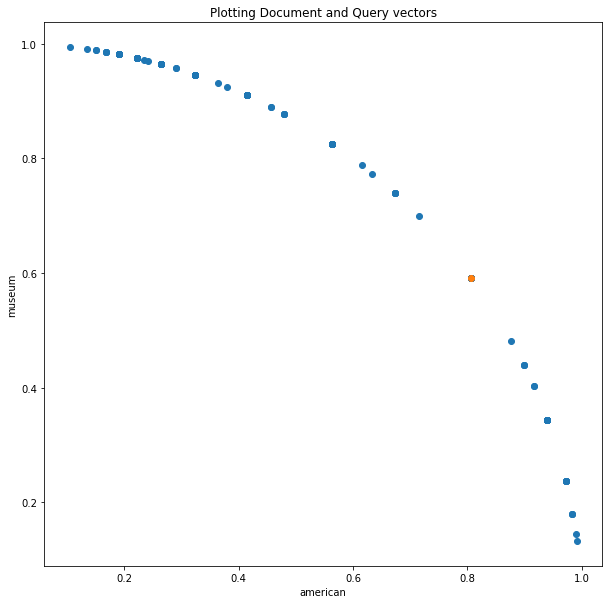

In [325]:
query='american museum'
document_id,query_document_vector=get_document_id_tf_idf_vector(query,vocabulary_df,inverted_index_tf_idf)

        
query_vector=get_query_vector(query,vocabulary_df,inverted_index_tf_idf,data_small)
x_axis=[i[0]/np.linalg.norm(i) for i in query_document_vector]
document_id,query_document_vector=get_document_id_tf_idf_vector(query,vocabulary_df,inverted_index_tf_idf)
y_axis=[i[1]/np.linalg.norm(i) for i in query_document_vector]

fig, axes = plt.subplots(1,figsize=(10,10))
plt.scatter(x=x_axis,y=y_axis)
plt.scatter(x=query_vector[0]/np.linalg.norm(query_vector),y=query_vector[1]/np.linalg.norm(query_vector))
axes.set_title('Plotting Document and Query vectors')
axes.set_xlabel('american')
axes.set_ylabel('museum')


# Q3. Define a new score!

### In this section we add some more features from the original dataset which would be required to calculate New Metrics

In [326]:

# warnings.filterwarnings("ignore")
data_small['numPeopleVisited']=data['numPeopleVisited']
data_small['numPeopleWant']=data['numPeopleWant']
data_small['placeAlt']=data['placeAlt']
data_small['placeLong']=data['placeLong']
data_small=data_small[['Hash_id','placeName', 'placeDesc', 'placeURL', 
       'numPeopleVisited', 'numPeopleWant', 'placeAlt', 'placeLong', 'placeDesc_processed']]
data_small

Hash_id                 placeName  \
0    -7737872234328599032         City Hall Station   
1     -332181580523064025         Highgate Cemetery   
2    -4247781851362255877         Leadenhall Market   
3     5639420487146964588            The Wave Organ   
4    -7966161558082850204       Catacombes de Paris   
...                   ...                       ...   
7195  -413205734206961666          Xul Solar Museum   
7196  3623449958306786746  Klatovy Catacomb Mummies   
7197 -5396697523725597622       Termesphere Gallery   
7198 -5422938830458947374              Wheeler Peak   
7199   968117651724880572                     Olana   

                                              placeDesc  \
0     The first New York City subway was built and o...   
1     Opened in 1839, Highgate is one of London’s mo...   
2     The ornate 19th-century painted roof and cobbl...   
3     Located on a jetty in the San Francisco Bay, t...   
4     In 2004, Parisian police were assigned to do a...   
...                                                 ...   
7195  With dreams of reforming and perfecting the un...   
7196  In an underground crypt beneath a Jesuit churc...   
7197  Most artists paint on a a flat plane, but in t...   
7198  At least six mountains in the southwestern Uni...   
7199  The Hudson River School of painters popularize...   

                                               placeURL  numPeopleVisited  \
0     https://www.atlasobscura.com/places/city-hall-...              1824   
1     https://www.atlasobscura.com/places/highgate-c...              2615   
2     https://www.atlasobscura.com/places/leadenhall...              3133   
3        https://www.atlasobscura.com/places/wave-organ              2426   
4     https://www.atlasobscura.com/places/catacombes...              4442   
...                                                 ...               ...   
7195  https://www.atlasobscura.com/places/xul-solar-...               129   
7196  https://www.atlasobscura.com/places/klatovy-ca...                49   
7197  https://www.atlasobscura.com/places/termespher...                71   
7198   https://www.atlasobscura.com/places/wheeler-peak               241   
7199          https://www.atlasobscura.com/places/olana               357   

      numPeopleWant  placeAlt  placeLong  \
0              8569   40.7134   -74.0046   
1              8179   51.5675    -0.1483   
2              7560   51.5126    -0.0834   
3              7400   37.8085  -122.4401   
4              7036   48.8343     2.3322   
...             ...       ...        ...   
7195            405  -34.5948   -58.4078   
7196            405   49.3951    13.2918   
7197            405   44.4574  -103.8258   
7198            405   36.6054  -105.4302   
7199            405   42.2171   -73.8293   

                                    placeDesc_processed  
0     [first, new, york, citi, subway, built, oper, ...  
1     [open, 1839, highgat, one, london, ’, infam, c...  
2     [ornat, 19thcenturi, paint, roof, cobbl, floor...  
3     [locat, jetti, san, francisco, bay, wave, orga...  
4     [2004, parisian, polic, assign, train, exercis...  
...                                                 ...  
7195  [dream, reform, perfect, univers, argentin, ar...  
7196  [underground, crypt, beneath, jesuit, church, ...  
7197  [artist, paint, flat, plane, termespher, galle...  
7198  [least, six, mountain, southwestern, unit, sta...  
7199  [hudson, river, school, painter, popular, roma...  

[7200 rows x 9 columns]

### *Metric One & Two*: 
> #### We define a new score based on either Number of People Visited the place(1) or Number of People who want to go the Place(2).
> #### For individual place the Visit_Score(1) or Visit_want_Score(2) is calculated as: $ \frac {Number-of-People-Visited}{Max-Number-of-People-visited(Based-on-all-the-places)}$
> #### This score is always bounded between $ [0,1] $ 
> #### We combine this score with Similarity as: $ Score = Similarity * VisitScore $
> #### In this way the final Score is always bounded between $ [0,1] $ 
> #### The Idea to use this metric is to give more weightage to more similar documents and popular places to visit.

In [327]:

def get_visit_score(visit,max_visit):
    """
    The get_visit_score calculate the normalised visit Score
       
    :visit:Float
    :max_visit: The maximium of Number of people visited the place or the Number of people who want to go to the place from the
     obtained dataset
    :returns: Visit_score:Float
    
    """    
    
### Get score for either People visited or people want to visit
    return visit/max_visit

### *Metric Three*:

> #### We define a new score based on the distance of the places from the current location of the user.
> #### Since distance can be arbitrarly large and we use angle between the place with respect to the earth center as distance measure.
> #### We use get_current_position fucntion to get the users current location.
> #### We use angleFromCoordinate function to get angle between two coordinates.
> #### We use get_position_score to caluclate the score based on the angle.The position score is defined as: $\frac {360-angleofplace}{360}$
> #### In this way we get more weightaage to places nearby.
> #### This score is always bounded between $ [0,1] $ 
> #### We combine this score with Similarity as: $ Score = Similarity * PositionScore $
> #### In this way the final Score is always bounded between $ [0,1] $ 
> #### The Idea to use this metric is to give more weightage to more similar documents and places near to the user.


In [328]:
def get_current_position():
    """
    The get_current_postions calcaulate the current Lat/Long of the user

    :returns: an object which as latlng stored in it's attributes
    
    """
    current_position=geocoder.ip('me')
    return current_position

In [329]:
def angleFromCoordinate(lat1, long1, lat2, long2): ###Reference:https://stackoverflow.com/questions/3932502/calculate-angle-between-two-latitude-longitude-points
    """
    The angleFromCoordinate calcalates the angle betweem current (lat,long) of the user to the place(lat,long)

    :lat1:Latitude of the user
    :long1:Longitutde of the user
    :lat2:Latitude of the place
    :long2:Longitude of the place
    :returns:angle between the two in degrees
    
    """    
    
    #### Get angle between two co-ordinates
    dLon = (long2 - long1)

    y = math.sin(dLon) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dLon)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise

    return brng

In [330]:
def getangle(c1,c2):
    """
    The getangle uses angleFromCoordinate functionality to calculate angle between places

    :c1:a object containing the user's current position
    :c2: a tuple of place (lat,long)
    :returns:angle between the place
    
    """   
    return angleFromCoordinate(c1.latlng[0], c1.latlng[1], c2[0], c2[1])

In [331]:
def get_postion_score(g,coord):
    
    """
    The get_postion_score function calculates the score of the place based on user current location

    :g:a object containing the user's current position
    :cord: a tuple of place (lat,long)
    :returns:The position scaore of the place
    
    """   
    angle_score=(360-getangle(g,coord))/360
   
    return  angle_score

### Using the ask_user_information function:

> #### In this way we ask the user more information about his/her preference in seeing the list of the places,so that the user find the more-accurate documents

In [332]:
def ask_user_information():
## Asking additional information from the user 
    print('1. Do you want  places to be closer to you?')
    print('2. Do you want to see places based on number of people that have visited the place?')
    print('3. Do you want to see places based on number of people who want to go the place?')
    x=int(input('Select from the given option:'))
    return x

### Search Engine 2.0

> #### Step-1 Get the Document vectors [tf_idf] of all the documents conatining the query using get_document_id_tf_idf_vector function.
> #### Step-2 Get the query_vector[tf_idf] of the query using the get_query_vector function
> #### Step-3 We intialise a metric(list) and convert it into heap structure to store a tuple containing (Score, Document_id)
>> #### Step-3.1: Here we have the possiblity to caluclate score in three ways:
>>> #### 1. Postion Based Score= Similarity * Position_Score
>>> #### 2. People who have visited Based Score= Similarity * Visit_Score
>>> #### 3. People who want to Visit Based Score= Similarity * Visit_Want Score

>#### Step-4 We iterate over the document vectors to caluclate the Score for the document and query. Further we store them in a heap data structure.
>> #### Step-4.1 We define a Max_length variable to make a heap of finite size(k)
>> #### Step-4.2 After we have added the K-documents of into the heap,we remove the document with minimum score and replace it with a new document, if and only if the new score is greater than minimum of the score of the documents present in the heap
>> #### Step-4.3 Orginally, Heapq module implements a minimum heap where the first element always has the minimum value.
> #### Step-5 After iterating over all the matched documents, we get the Dataframe of the documents having the field[Tittle,Place Descritiopn,Place URL] using the final Heap.

In [333]:
def Search_engine_top_k_v2(query,vocabulary_df,inverted_index_dataframe,data_des,k):
    i=ask_user_information()
    if i==1:
        ### Get document id common to all queries and it's tf_id representation
        document_id,query_document_vector=get_document_id_tf_idf_vector(query,vocabulary_df,inverted_index_dataframe)
        
        ### Get Query Vector
        query_vector=get_query_vector(query,vocabulary_df,inverted_index_dataframe,data_des)
        
        ### Scoring Metric defined for this choice
        metric=[]
        
        #### Converting list to heap
        heapq.heapify(metric)
        
        ### Get my current position
        g=get_current_position()
        
        ### Variable for top_k documents
        max_length=k
        
        #### Iterate over the document id's and get similarity score & Position Score for each document to get the final score
        for i,j in enumerate(document_id):
                     ### Get co-ordinates of the place   
                     coord=data_des[data_des.Hash_id.isin([j])].loc[:,['placeAlt','placeLong']].values[0]
                    
                     ### Find the angle with respect to the location
                     position_score=get_postion_score(g,coord)
                    
                     ### Cosine Similarity based on tf_idf representation of the document
                     similarity=calculate_cosine_similarity(query_vector,query_document_vector[i])
                     ### Final Score for the document
                     score=position_score*similarity
                     ### Storing upto the size of the heap
                     if i<max_length:
                        heappush(metric,(score,j))

                    ## Replacing the minumum element from the heap(Gaol is to maintain the top scores)
                     else:
                        if score>metric[0][0]:
                            heapreplace(metric,(score,j))
                            
        ### Get the sorted order of the metric: Each element is (Score,Document_id)        
        metric=heapq.nlargest(k,metric)
        
        ### Get the Final DataFrame
        for i,j in enumerate(metric):
                if i==0:
                    final_df=data_des[data_des.Hash_id.isin([j[1]])]
                    final_df=final_df.assign(Score=j[0])
                else:
                    x=data_des[data_des.Hash_id.isin([j[1]])]
                    x=x.assign(Score=j[0])
                    final_df=pd.concat([final_df,x]) 
                
        return final_df.drop(['placeDesc_processed','Hash_id','numPeopleVisited','numPeopleWant','placeAlt','placeLong'],axis=1)
    
    #### The syntax of the code is quite similar as present for i==1.Refer to that to get more information.
    elif i==2:
        ###Score based on Number of People who visited the place
        
        document_id,query_document_vector=get_document_id_tf_idf_vector(query,vocabulary_df,inverted_index_dataframe)
        query_vector=get_query_vector(query,vocabulary_df,inverted_index_dataframe,data_des)
        metric=[]
        heapq.heapify(metric)
        
        ### Getting Max of the number of people who have visited the place from the dataset
        max_visit=data_des[data_des.Hash_id.isin(document_id)].numPeopleVisited.max()

        max_length=k
        for i,j in enumerate(document_id):

                     visit=data_des[data_des.Hash_id.isin([j])].loc[:,['numPeopleVisited']].values[0]
                     visit_score=get_visit_score(visit,max_visit)

                     similarity=calculate_cosine_similarity(query_vector,query_document_vector[i])

                     score=visit_score*similarity

                     if i<max_length:
                        heappush(metric,(score,j))


                     else:
                        if score>metric[0][0]:
                            heapreplace(metric,(score,j))
        metric=heapq.nlargest(k,metric)
        for i,j in enumerate(metric):
                if i==0:
                    final_df=data_des[data_des.Hash_id.isin([j[1]])]
                    final_df=final_df.assign(Score=j[0])
                else:
                    x=data_des[data_des.Hash_id.isin([j[1]])]
                    x=x.assign(Score=j[0])
                    final_df=pd.concat([final_df,x]) 
        
        return final_df.drop(['placeDesc_processed','Hash_id','numPeopleVisited','numPeopleWant','placeAlt','placeLong'],axis=1)
    
    elif i==3:
        ###Score based on Number of People who want to visit
        document_id,query_document_vector=get_document_id_tf_idf_vector(query,vocabulary_df,inverted_index_dataframe)
        
        query_vector=get_query_vector(query,vocabulary_df,inverted_index_dataframe,data_des)
        metric=[]
        heapq.heapify(metric)
        
        ### Getting Max of the number of people who want to visit the place from the dataset
        max_visit_want=data_des[data_des.Hash_id.isin(document_id)].numPeopleWant.max()

        max_length=k
        for i,j in enumerate(document_id):
           
             visit_want=data_des[data_des.Hash_id.isin([j])].loc[:,['numPeopleWant']].values[0]
             visit_want_score=get_visit_score(visit_want,max_visit_want)
            
             similarity=calculate_cosine_similarity(query_vector,query_document_vector[i])
             
             score=visit_want_score*similarity
             
             if i<max_length:
                heappush(metric,(score,j))
                
                
             else:
                if score>metric[0][0]:
                    heapreplace(metric,(score,j))
        metric=heapq.nlargest(k,metric)
        
        for i,j in enumerate(metric):
                if i==0:
                    final_df=data_des[data_des.Hash_id.isin([j[1]])]
                    final_df=final_df.assign(Score=j[0])
                else:
                    x=data_des[data_des.Hash_id.isin([j[1]])]
                    x=x.assign(Score=j[0])
                    final_df=pd.concat([final_df,x]) 
        return final_df.drop(['placeDesc_processed','Hash_id','numPeopleVisited','numPeopleWant','placeAlt','placeLong'],axis=1)
        
    
        

### Example Case1 using Metric 3

In [334]:
query='american museum'
Search_engine_top_k_v2(query,vocabulary_df,inverted_index_tf_idf,data_small,100)

1. Do you want  places to be closer to you?
2. Do you want to see places based on number of people that have visited the place?
3. Do you want to see places based on number of people who want to go the place?
Select from the given option:1


placeName  \
5067            Moundville Archaeological Site   
6711                              Topaz Museum   
6202                    Siriraj Medical Museum   
985                Horniman Museum and Gardens   
2655                Cabaret Mechanical Theatre   
...                                        ...   
3757                      Murals of Maxo Vanka   
3768                           Double Negative   
5570                Studebaker National Museum   
4544                        RV/MH Hall of Fame   
6044  National Cookie Cutter Historical Museum   

                                              placeDesc  \
5067  Not far from Tuscaloosa, Alabama is a window t...   
6711  On February 19, 1942, President Franklin Delan...   
6202  The Siriraj Medical Museum abounds with medica...   
985   London’s Horniman Museum has been showing off ...   
2655  It’s not a theater and it’s not a cabaret, so ...   
...                                                 ...   
3757  Created in protest against industrial capitali...   
3768  “There is nothing there, yet it is still a scu...   
5570  At the Studebaker National Museum, visitors ca...   
4544  Almost since the invention of the automobile, ...   
6044  A sugar cookie is essentially just a baked lum...   

                                               placeURL     Score  
5067  https://www.atlasobscura.com/places/moundville...  0.999306  
6711   https://www.atlasobscura.com/places/topaz-museum  0.994069  
6202  https://www.atlasobscura.com/places/siriraj-me...  0.993341  
985   https://www.atlasobscura.com/places/horniman-m...  0.992089  
2655  https://www.atlasobscura.com/places/cabaret-me...  0.990932  
...                                                 ...       ...  
3757  https://www.atlasobscura.com/places/murals-of-...  0.594132  
3768  https://www.atlasobscura.com/places/double-neg...  0.572407  
5570  https://www.atlasobscura.com/places/studebaker...  0.571996  
4544  https://www.atlasobscura.com/places/rvmh-hall-...  0.571870  
6044  https://www.atlasobscura.com/places/national-c...  0.571090  

[100 rows x 4 columns]

### Example Case2 using Metric 1

In [335]:
query='american museum'
Search_engine_top_k_v2(query,vocabulary_df,inverted_index_tf_idf,data_small,100)

1. Do you want  places to be closer to you?
2. Do you want to see places based on number of people that have visited the place?
3. Do you want to see places based on number of people who want to go the place?
Select from the given option:2


placeName  \
59                  The Witch House of Salem   
1406                            Blue Mustang   
969                     Crazy Horse Memorial   
3196                                   U-505   
2657                    Milwaukee Art Museum   
...                                      ...   
1538  National Museum of Health and Medicine   
1425                         Hamilton Grange   
3891              Wonders of Wildlife Museum   
3806                  Pacific Pinball Museum   
5726                           Orchard House   

                                              placeDesc  \
59    The Salem witchcraft trials took place between...   
1406  The “Blue Mustang” sculpture was created by th...   
969   When the carving of Mount Rushmore began in 19...   
3196  One of only four remaining U-boats in the worl...   
2657  Like the Guggenheim in New York and the Oaklan...   
...                                                 ...   
1538  Once housed in downtown Washington, D.C. , the...   
1425  Built in the pastoral expanses of colonial Har...   
3891  Located right next door to the massive Bass Pr...   
3806  Once called Bagatelle, pinball descended from ...   
5726  The Orchard House was purchased by Louisa May ...   

                                               placeURL     Score  
59    https://www.atlasobscura.com/places/witch-hous...  0.905990  
1406   https://www.atlasobscura.com/places/blue-mustang  0.734351  
969   https://www.atlasobscura.com/places/crazy-hors...  0.701277  
3196          https://www.atlasobscura.com/places/u-505  0.513339  
2657  https://www.atlasobscura.com/places/milwaukee-...  0.472055  
...                                                 ...       ...  
1538  https://www.atlasobscura.com/places/national-m...  0.102035  
1425  https://www.atlasobscura.com/places/hamilton-g...  0.101756  
3891  https://www.atlasobscura.com/places/wonders-of...  0.101462  
3806  https://www.atlasobscura.com/places/pacific-pi...  0.101462  
5726  https://www.atlasobscura.com/places/louisa-may...  0.099719  

[100 rows x 4 columns]

### Example Case3 using Metric 2

In [336]:
query='american museum'
Search_engine_top_k_v2(query,vocabulary_df,inverted_index_tf_idf,data_small,100)

1. Do you want  places to be closer to you?
2. Do you want to see places based on number of people that have visited the place?
3. Do you want to see places based on number of people who want to go the place?
Select from the given option:3


placeName  \
59          The Witch House of Salem   
173   National Atomic Testing Museum   
141              Museum of the Weird   
224          Canyons of the Ancients   
329                 Uncommon Objects   
...                              ...   
2791                    Drayton Hall   
3407    Geppi's Entertainment Museum   
3611              The Big Mac Museum   
2947                   Aria Antiques   
3719           Media Archaeology Lab   

                                              placeDesc  \
59    The Salem witchcraft trials took place between...   
173   Las Vegas is an oasis in the desert where no o...   
141   The dime or dime store museum is by all accoun...   
224   Ripe for quiet reflection and simply awe-inspi...   
329   Like an elegant antiques mall gone horribly wr...   
...                                                 ...   
2791  Considered one of the most beautiful examples ...   
3407  It’s a unique place that can create a sentimen...   
3611  The Irwin, Pennsylvania McDonald’s location de...   
2947  Tucked between the Italian bakeries and laundr...   
3719  The Media Archaeology Lab couldn’t have picked...   

                                               placeURL     Score  
59    https://www.atlasobscura.com/places/witch-hous...  1.000000  
173   https://www.atlasobscura.com/places/national-a...  0.678868  
141    https://www.atlasobscura.com/places/museum-weird  0.672343  
224   https://www.atlasobscura.com/places/canyons-of...  0.616954  
329   https://www.atlasobscura.com/places/uncommon-o...  0.565833  
...                                                 ...       ...  
2791   https://www.atlasobscura.com/places/drayton-hall  0.178274  
3407  https://www.atlasobscura.com/places/geppi-s-en...  0.178089  
3611  https://www.atlasobscura.com/places/the-big-ma...  0.173616  
2947  https://www.atlasobscura.com/places/aria-antiques  0.172544  
3719  https://www.atlasobscura.com/places/media-arch...  0.170584  

[100 rows x 4 columns]

### Comments:
> ### The Scoring Function defined for Questions 3 are more oriented towards the needs of the user. 
> ### THe Scoring Function defined in Q2(Cosine Similairity) is used to rank the places and the top ranked places might be irrevlevant based on the needs of the user.
> ### For example if the users inputs some query related to Place desciption and he expects that the places that he should get be closer to him. This is not taken care by the scoring function in defined Q2.This is taken care by Metric 3 defined in Q3.

### Q4: Visualizing the most relevant places

### Here we used the functionality of plotly library to produce Maps

> #### The legend in the map,is based on the cosine similarity between places.
> #### THe size of the dots is based on the number of people visited

In [337]:
###Adding information to the dataset from the main dataset to get the values of variables of interest.
data_small['placeTags']=data['placeTags']
data_small['placeAddress']=data['placeAddress']

### Ask user to enter query
query=input("Enter your Query:")

### Getting top 100 documents from the search engine
dataset=Search_engine_top_k(query,vocabulary_df,inverted_index_tf_idf,data_small,100)

### Plot the maps
fig = px.scatter_mapbox(dataset,title = 'Place Atlas', lat="placeAlt", lon="placeLong", hover_name="placeName", hover_data=["placeTags", "placeAddress"],
                        color_continuous_scale=px.colors.sequential.Viridis, color="Score",size="numPeopleVisited", zoom=4, height=500
                       )

fig.update_layout(
    mapbox_style="open-street-map",
    )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.update(layout={'title': {'x': 0.5, 'y': 1}})

fig.show()

Enter your Query:american museum


# BONUS: More complex search engine

### Slicing the dataframe to get variable of interest required by the given problem

> #### We add three new additional columns which are basically modified version of 'placeDesc','placeAddress','placeName' using preprocess function
> #### This was done in view of preparing the three new inverted_index


In [338]:
## For each document combining the three different columns and preprocessing the values to get all the required words
data_small=data[['placeDesc','placeAddress','placeName','placeEditors','placeTags','numPeopleVisited','placeRelatedLists']]
data_small['placeName_processed']=data_small['placeName'].apply(lambda row:preprocess(row))
data_small['placeAddress_processed']=data_small['placeAddress'].apply(lambda row:preprocess(row))
data_small['placeDesc_processed']=data_small['placeDesc'].apply(lambda row:preprocess(row))
data_small

placeDesc  \
0     The first New York City subway was built and o...   
1     Opened in 1839, Highgate is one of London’s mo...   
2     The ornate 19th-century painted roof and cobbl...   
3     Located on a jetty in the San Francisco Bay, t...   
4     In 2004, Parisian police were assigned to do a...   
...                                                 ...   
7195  With dreams of reforming and perfecting the un...   
7196  In an underground crypt beneath a Jesuit churc...   
7197  Most artists paint on a a flat plane, but in t...   
7198  At least six mountains in the southwestern Uni...   
7199  The Hudson River School of painters popularize...   

                                           placeAddress  \
0     31 Centre St New York, New York, 10007 United ...   
1     Swain's Lane, Highgate London, England, N6 Uni...   
2                 London, England, EC3V United Kingdom    
3     83 Marina Green Dr San Francisco, California, ...   
4        1 Place Denfert-Rochereau Paris, 75014 France    
...                                                 ...   
7195               Laprida 1212 Buenos Aires Argentina    
7196                          Denisova Klatovy Czechia    
7197  1920 Christensen Drive Spearfish, South Dakota...   
7198  Wheeler Peak Taos Ski Valley, New Mexico, 8752...   
7199  Olana State Historic Site 5720 Route 9G Hudson...   

                     placeName  \
0            City Hall Station   
1            Highgate Cemetery   
2            Leadenhall Market   
3               The Wave Organ   
4          Catacombes de Paris   
...                        ...   
7195          Xul Solar Museum   
7196  Klatovy Catacomb Mummies   
7197       Termesphere Gallery   
7198              Wheeler Peak   
7199                     Olana   

                                           placeEditors  \
0     ['charding407', 'fosterc827', 'Mike H', 'erjef...   
1     ['thesecretcity', 'thedyerghoulhouse', 'juliap...   
2     ['Julius Spada', 'Katecrimson', 'thesecretcity...   
3     ['routt1111', 'wefiddleboy14', 'Saal333', 'Nei...   
4     ['marypippen', 'ramonrodz2212', 'mathewbrowne'...   
...                                                 ...   
7195                                        ['Allison']   
7196         ['Max Cortesi ', ' hrnick ', ' marjolein']   
7197                                        ['kgsn143']   
7198                                     ['mikewalker']   
7199  ['hannsharonr', 'horticulturcat', 'lisefrac', ...   

                        placeTags  numPeopleVisited  \
0             Manhattan, New York              1824   
1                 London, England              2615   
2                 London, England              3133   
3       San Francisco, California              2426   
4                   Paris, France              4442   
...                           ...               ...   
7195      Buenos Aires, Argentina               129   
7196             Klatovy, Czechia                49   
7197      Spearfish, South Dakota                71   
7198  Taos Ski Valley, New Mexico               241   
7199             Hudson, New York               357   

                                      placeRelatedLists  \
0     ['30 Unexpected Places to Have a Joyful Advent...   
1     ["The World's Top 100 Wonders in 2018", "Londo...   
2     ['The Ultimate Guide to Stunning, Surprising, ...   
3     ["Leonardo Nam's 16 Quirky Roadside Attraction...   
4     ['19 Catacombs Sure to Tingle Your Spine', "Th...   
...                                                 ...   
7195        ["A Linguistics Lover's Tour of the World"]   
7196  ['19 Catacombs Sure to Tingle Your Spine', "Bo...   
7197                                                NaN   
7198                  ['The Highest Places in America']   
7199                                                NaN   

             placeName_processed  \
0          [citi, hall, station]   
1            [highgat, cemeteri]   
2            [leadenhal, market]

### Inverted Index:

> #### Step-1: We defined a list of variable from which the three different inverted index would be created.Since we already have stored in the preprocessed features in the dataset using previous step,we can skip the pre-processing here.
> #### Step-2: Now for each variable[Name/Address/Description]We combine the list of processed words for all the documents to a single list and pass it to a counter object to obtained a dictionary of unique words.
> #### Step-3: We create a Vocabulary Dataframe using the unique words and also compute it's Id using Hash Function.
> #### Step-4: Using the obtained Vocabulary of unique words we create the inverted_index for the dataset
>> #### Step-4.1: We intialse an inverted_index dictionary with keys as Unique words obtained from the vocabulary_df and value as an empty list
>> #### Step-4.2: Then we iterate over the documents. Now for a single document, we used the stored processed column of place description to find the unique words.
>> #### Step-4.3:Then for all the unique words(keys) found in the description for that place we append the {document_id and Term_frequency} .We repeat this for all the documents.
> #### Step-5 Finally from the obtained dictionary of the inverted-index we convert it into Pandas DataFrame.
> #### Step-6 Now, we compute the IDF score for all the words and modify the list of dictionaries [{document1_id: term_frequency},{document2_id: term_frequency},......] for each word to [{document1_id: tf_idf},{document2_id: tf_idf},......] using get_tf_idf function
> #### Step-7 We store the three vocabulary and inverted_index in two dictionaries hist_voc and hist_inverted_index respectively.


In [339]:
def inverted_index(data_small):
    param=['placeAddress_processed','placeName_processed','placeDesc_processed']
    hist_voc={}
    hist_inverted_index={}
    document_id=[]
    for i in param:
            ### Combining all the words for all the document from 'placeDesc_processed' in a common list
        word_list=list(itertools.chain.from_iterable(data_small[i].values)) ###Combine all the rows

        ### Passing the list to counter object to get unique words 
        word_counter=Counter(word_list)### Find unique words

        ### Create vocabulary dictionary of word(key) and it's id(value)
        vocabulary={key:hash(key) for key in word_counter.keys()} 

        ### Converting the dictionary to Pandas dataframe
        vocabulary_df=pd.DataFrame.from_dict(vocabulary,orient='index',columns=['Term_id'])
        
        ### Store it into hist_voc dictionary
        hist_voc[i]=vocabulary_df
        
        inverted_index={key:[] for key in vocabulary.keys()}

        ### Create a dictionary of Inverted_index with word(key) and empty list as value
        inverted_index={key:[] for key in vocabulary.keys()}

        ### Iterating over the individual documment 'placeDesc_processed' column of data_small to get the unique words present in
        ### Document
        for doc_num,j in tq(enumerate(data_small[i].values)):
            ### Finding the unique words in the list of words for individual document
            unique_j=list(set(j))

            ###Since these unique words would be present in Vocabulary and hence in the Inverted_index dictionary, for individual words
            ### I append a dictionary element to the Inverted_index[word] which is {document_id: Term_freqeuncy}

            for k in unique_j: ## Iterating over the unique words of the document

                ## Appending a dictionary to list and calculating the term frequency using list.count() method
                inverted_index[k].append(dict({hash('document'+str(doc_num)):(j.count(k)/len(j))}))

            ### Appending the generated document_id's
            if len(document_id)<len(data_small):
                document_id.append(hash('document'+str(doc_num)))

        ### For dataframe to assign a complete list to a single cell it has to be list(list(value)),Further the inverted_index dictionary
        ### individual element is modified in the following order:{word:[[{document1_id: term_frequency},{document2_id: term_frequency},......]]} 

        inverted_index={ k:[v] for k,v in inverted_index.items()}

        ### Converting inverted_index dictionary to DataFrame
        inverted_index_df = pd.DataFrame.from_dict(inverted_index,orient='index',columns=['tf_id'])

        ### Adding the Term_id's of the word to the DataFrame
        inverted_index_df['Term_id']=vocabulary_df['Term_id']

        ###Changing the order of the columns
        inverted_index_df_tf=inverted_index_df[['Term_id','tf_id']]

        ###Converting the list of dictionary:[{document1_id: term_frequency},{document2_id: term_frequency},......] for individual word/term_id's 
        ### to [{document1_id: tf_idf},{document2_id: tf_idf},......]
        inverted_index_df_tf[inverted_index_df_tf.columns.values[-1]].apply(lambda row:get_tf_idf(len(data_small),row))

        ### Renaming the Column to respresent Tf-idf column
        inverted_index_df_idf=inverted_index_df_tf
        inverted_index_df_idf.rename(columns={'tf_id':'tf_idf'},inplace=True)
        
        #Store into hist_inverted_index dictionary 
        hist_inverted_index[i]=inverted_index_df_idf
    return hist_voc,hist_inverted_index,document_id

### Getting the three vocabulary and inverted_index

In [340]:
vocabulary,inverted_index_tf_idf,document_id=inverted_index(data_small) 

7200it [00:00, 110888.71it/s]
7200it [00:00, 267392.03it/s]
7200it [00:02, 3075.12it/s]


### Adding Document ID's to the dataset

In [341]:
data_small['Hash_id']=document_id
data_small

placeDesc  \
0     The first New York City subway was built and o...   
1     Opened in 1839, Highgate is one of London’s mo...   
2     The ornate 19th-century painted roof and cobbl...   
3     Located on a jetty in the San Francisco Bay, t...   
4     In 2004, Parisian police were assigned to do a...   
...                                                 ...   
7195  With dreams of reforming and perfecting the un...   
7196  In an underground crypt beneath a Jesuit churc...   
7197  Most artists paint on a a flat plane, but in t...   
7198  At least six mountains in the southwestern Uni...   
7199  The Hudson River School of painters popularize...   

                                           placeAddress  \
0     31 Centre St New York, New York, 10007 United ...   
1     Swain's Lane, Highgate London, England, N6 Uni...   
2                 London, England, EC3V United Kingdom    
3     83 Marina Green Dr San Francisco, California, ...   
4        1 Place Denfert-Rochereau Paris, 75014 France    
...                                                 ...   
7195               Laprida 1212 Buenos Aires Argentina    
7196                          Denisova Klatovy Czechia    
7197  1920 Christensen Drive Spearfish, South Dakota...   
7198  Wheeler Peak Taos Ski Valley, New Mexico, 8752...   
7199  Olana State Historic Site 5720 Route 9G Hudson...   

                     placeName  \
0            City Hall Station   
1            Highgate Cemetery   
2            Leadenhall Market   
3               The Wave Organ   
4          Catacombes de Paris   
...                        ...   
7195          Xul Solar Museum   
7196  Klatovy Catacomb Mummies   
7197       Termesphere Gallery   
7198              Wheeler Peak   
7199                     Olana   

                                           placeEditors  \
0     ['charding407', 'fosterc827', 'Mike H', 'erjef...   
1     ['thesecretcity', 'thedyerghoulhouse', 'juliap...   
2     ['Julius Spada', 'Katecrimson', 'thesecretcity...   
3     ['routt1111', 'wefiddleboy14', 'Saal333', 'Nei...   
4     ['marypippen', 'ramonrodz2212', 'mathewbrowne'...   
...                                                 ...   
7195                                        ['Allison']   
7196         ['Max Cortesi ', ' hrnick ', ' marjolein']   
7197                                        ['kgsn143']   
7198                                     ['mikewalker']   
7199  ['hannsharonr', 'horticulturcat', 'lisefrac', ...   

                        placeTags  numPeopleVisited  \
0             Manhattan, New York              1824   
1                 London, England              2615   
2                 London, England              3133   
3       San Francisco, California              2426   
4                   Paris, France              4442   
...                           ...               ...   
7195      Buenos Aires, Argentina               129   
7196             Klatovy, Czechia                49   
7197      Spearfish, South Dakota                71   
7198  Taos Ski Valley, New Mexico               241   
7199             Hudson, New York               357   

                                      placeRelatedLists  \
0     ['30 Unexpected Places to Have a Joyful Advent...   
1     ["The World's Top 100 Wonders in 2018", "Londo...   
2     ['The Ultimate Guide to Stunning, Surprising, ...   
3     ["Leonardo Nam's 16 Quirky Roadside Attraction...   
4     ['19 Catacombs Sure to Tingle Your Spine', "Th...   
...                                                 ...   
7195        ["A Linguistics Lover's Tour of the World"]   
7196  ['19 Catacombs Sure to Tingle Your Spine', "Bo...   
7197                                                NaN   
7198                  ['The Highest Places in America']   
7199                                                NaN   

             placeName_processed  \
0          [citi, hall, station]   
1            [highgat, cemeteri]   
2            [leadenhal, market]

### Example of Vocabulary created from Place Name

In [342]:
vocabulary['placeName_processed']

Term_id
citi        7711874059208919467
hall        8225209342716920903
station    -1128020583644961013
highgat     2108505730988811314
cemeteri   -1368128622549488407
...                         ...
cook       -1140958288721010274
xul         -918171206203877797
klatovi    -4946571165791930321
termespher  3277234754182892743
olana      -4658011957986953236

[7870 rows x 1 columns]

### Example of Inverted_index created from Place Name

In [343]:
inverted_index_tf_idf['placeName_processed']

Term_id  \
citi        7711874059208919467   
hall        8225209342716920903   
station    -1128020583644961013   
highgat     2108505730988811314   
cemeteri   -1368128622549488407   
...                         ...   
cook       -1140958288721010274   
xul         -918171206203877797   
klatovi    -4946571165791930321   
termespher  3277234754182892743   
olana      -4658011957986953236   

                                                       tf_idf  
citi        [{-7737872234328599032: 1.5492432668022957}, {...  
hall        [{-7737872234328599032: 1.6843983028383507}, {...  
station     [{-7737872234328599032: 1.6992155570286285}, {...  
highgat            [{-332181580523064025: 4.440918152502073}]  
cemeteri    [{-332181580523064025: 2.086153051845906}, {-4...  
...                                                       ...  
cook                [{405141104165052942: 4.440918152502073}]  
xul               [{-413205734206961666: 2.9606121016680484}]  
klatovi           [{3623449958306786746: 2.9606121016680484}]  
termespher        [{-5396697523725597622: 4.440918152502073}]  
olana               [{968117651724880572: 8.881836305004146}]  

[7870 rows x 2 columns]

### Instructions for Creating Query

> ### Formats Searching
>> #### If you want to give name of the place you are searching for give *Name:The name of the place*
>> #### If you want to give address of the place you are searching for give *Add:Address of the place*
>> #### If you want to give Description of the place you are searching for give *Des:Description of the place*

> ### Formats Filtering
>> #### If you want to filter based on the username contributed to the posts give *f1:Name of the users*. Note if you want to give multiple user names the format should be *f1:user1;user2;...*
>> #### If you want to filter based on the placetags of the places *f2:placeTags*.  Note if you want to give multiple user names the format should be *f2:placeTag1;placeTag2;...*
>> #### If you want to filter based on the upper bound of number of people visited give *f3U:The max limit*.
>> #### If you want to filter based on the lower bound of number of people visited give *f3L:The min limit*.
>> #### If you want to filter based on the list names in which the place we included give *f4:placelists*.

> ### Combine Format for query is:
>> #### *Name:The name of the place*,*Add:Address of the place*,*Des:Description of the place*-*f1:Name of the users*,*f2:placeTags*,*f3U:The max limit*,*f3L:The min limit*,*f4:placelists*
>> #### Within Searching elements have to be sepereted by comma
>> #### To specifiy filter it should start with '-' and all the elements are seperated by comma

> ### Example case of Queries which can be input by the user
>> #### 'Name:museum,Add:atlanta,Des:american museum-f1:Aty Trocious;Jack,f2:Denver,f3U:4000,f3L:1000,f4:17 Places to Hunt for Aliens Besides Area 51'
>> #### 'Name:Cafebrería,Add:alejandro,Des:first think-f1:linkogecko,f2:,f3U:500,f3L:100'



### Function to process the query given by the user
> #### It creates two lists which are the queries to search for and the filters to be used to filter the queried documents

In [344]:
def query_process(query):
    """
    query:str
    returns: query1: list of dictionaries for searching elements
    returns: filter1:list of dictionaries for filtering
    
    """
    # divide query in two part [Name:xxx, Des:xxx, Add:xxx], [f1:xxx,..., f4:xxx]
    query=query.split('-') ### Splitting Search and filtering elements
    query1=query[0]
    query1=query1.split(',')
    query1=[ dict({i.split(':')[0]:i.split(':')[1]}) for i in query1] ### Creating dictionary of searching elements
    try:
        filter1=query[1]
        filter1=filter1.split(',')
        filter1=[dict({i.split(':')[0]:i.split(':')[1].split(';')}) for i in filter1] ### Creating dictionary of filtering elements
    except:
        filter1=''

    return query1,filter1

### Example Case of working of query_process:


In [345]:
query='Name:museum,Add:Atlanta,Des:american museum-f1:Aty Trocious;SquiddyGiggles,f2:Denver,f3U:4000,f3L:1000,f4:17 Places to Hunt for Aliens Besides Area 51'
query,filt= query_process(query)

query,filt

([{'Name': 'museum'}, {'Add': 'Atlanta'}, {'Des': 'american museum'}],
 [{'f1': ['Aty Trocious', 'SquiddyGiggles']},
  {'f2': ['Denver']},
  {'f3U': ['4000']},
  {'f3L': ['1000']},
  {'f4': ['17 Places to Hunt for Aliens Besides Area 51']}])

### Funtion to check if an given list elements are present in the another list

> #### Would be used for 'placeEditors',''placeTags','placeRelatedLists' to find if a list of given usersname/placenames/placelists are all present in a particular document

In [346]:
def filter_(row,list1):
   """
    row:a list of values present in the document for either 'placeEditors',''placeTags','placeRelatedLists'
    list1: The list of usersname/placenames/placelists if they are all present in the document
    returns: Bolean:True if present or False if not present
    
   """
   x=0
   for i in list1: ### check counting the elements contained in the row(main list)
     try:
        if i in row:
            x+=1
       
     except:
        continue
   if x==len(list1):
        
       return True
   else:
       return False

### Function to filter the dataset  based on the input query by the user

In [347]:
def filt(fil,data):
        """
        :fill:The list of dictionaries conatained the filter elements
        :data:Pandas DataFrame,this is the combined dataframe obtained from using all the search elemets
         returns: Pandas DataFrame, return the filtered dataframe obtained based on the elements in fill

        """

        ### filter the dataset using the filter_ function


        for i in fil:
#                 
                if list(i.keys())[0]=='f1':
                    data = data[data['placeEditors'].apply(lambda row: filter_(row,list(fil[0].values())[0]))]

                if list(i.keys())[0]=='f2':
                    data = data[data['placeTags'].apply(lambda row: filter_(row,list(fil[1].values())[0]))]

                if list(i.keys())[0]=='f3U':
#                    
                    data = data[data['numPeopleVisited']<=int(list(fil[2].values())[0][0])]

                if list(i.keys())[0]=='f3L':
                    data = data[data['numPeopleVisited']>=int(list(fil[3].values())[0][0])]

                if list(i.keys())[0]=='f4':
                    data = data[data['placeRelatedLists'].apply(lambda row: filter_(row,list(fil[4].values())[0]))]

        return data


In [348]:
def combine_rows_df(df,l1):
   
    y=df.groupby([df.index])[l1].sum()
    z=df.groupby([df.index])
    a=z.first()
    for i in l1:
        a[i]=y[i]


    return a

### Search Engine 3.0
> #### Step-1 We process the query to get elements meant for searching and filtering(query,fill)
> #### Step-2 We defined a dictionary (param_dict) which helps the function to identify which inverted index and vocabulary to use.
> #### Step-3 Now we iterate over the searching elements(Name,Address or Description) and find the documents in the following way
>> #### Get the Document vectors [tf_idf] of all the documents conatining the query using get_document_id_tf_idf_vector function.
>> #### Get the query_vector[tf_idf] of the query using the get_query_vector function
>> #### We intialise a metric(list) and convert it into heap structure to store a tuple containing (Cosine_Similarity, Document_id)
>> #### We iterate over the document vectors to caluclate the simlarity for the document and query. Further we store them in a heap data structure.
>>> ####  We define a Max_length variable to make a heap of finite size(k)
>>> #### After we have added the K-documents of into the heap,we remove the document with minimum score and replace it with a new document, if and only if the new score is greater than minimum of the score of the documents present in the heap
>>> #### Orginally, Heapq module implements a minimum heap where the first element always has the minimum value.
>> ####  After iterating over all the matched documents, we get the Dataframe of the documents using the final Heap.
> #### Step-4 We combined all the filtered Documents DataFrame for all the Searching elements and compute the final Score using combine_rows_df function.
> #### Step-5 Once we have all the documents for all the searching parts of the query,we filter the documents based on the filtering criteria given by the user using filt and filter_ function.
> #### Step-6 Computing Final Score:
>> #### If all the Name,Address and Description field are present, we assign the scores resulted from each field with weight as 0.4,0.4,0.2 respectively and sum them.
>> #### If only Name,Address field are present, we assign the scores resulted from each field with weight as 0.6,0.4 respectively and sum them.
>> #### If only Name,Desc field are present, we assign the scores resulted from each field with weight as 0.7,0.3 respectively and sum them.
>> #### If only Address,Desc field are present, we assign the scores resulted from each field with weight as 0.7,0.3 respectively and sum them.
>> #### If only one field is present(Name/Desc/Address) we take the original Score(cosine similarity) as the final score.

In [349]:
def Search_engine_top_k_par(query,vocabulary_df,inverted_index_dataframe,data_des,k):
        
    param_dict={'Name':'placeName_processed','Add':'placeAddress_processed','Des':'placeDesc_processed'}
    query,fil=query_process(query) 
    keys=[list(i.keys())[0] for i in query]

    df_list=[]

    for i in query:
        par=param_dict[list(i.keys())[0]] 
        
        part_query=list(i.values())[0]

        ### Get document id common to all queries and it's tf_id representation
        document_id,query_document_vector=get_document_id_tf_idf_vector(part_query,vocabulary_df[par],inverted_index_dataframe[par])
      
        ### Get Query Vector
        query_vector=get_query_vector(part_query,vocabulary_df[par],inverted_index_dataframe[par],data_des)
        
        ### Scoring Metric defined for this choice
        metric=[]

        #### Converting list to heap
        heapq.heapify(metric)

        ### Variable for top_k documents
        max_length = k

        #### Iterate over the document id's and get similarity score & Position Score for each document to get the final score
        for i,j in enumerate(document_id):


                     ### Cosine Similarity based on tf_idf representation of the document
                     score=calculate_cosine_similarity(query_vector,query_document_vector[i])

                     ### Storing upto the size of the heap
                     if i<max_length:
                        heappush(metric,(score,j))

                    ## Replacing the minumum element from the heap(Gaol is to maintain the top scores)
                     else:
                        if score>metric[0][0]:
                            heapreplace(metric,(score,j))

        ### Get the sorted order of the metric: Each element is (Score,Document_id)        
        metric=heapq.nlargest(k,metric)

        ### Get the Final DataFrame
        for i,j in enumerate(metric):
            if i==0:
                final_df=data_des[data_des.Hash_id.isin([j[1]])]
                final_df=final_df.assign(Score=j[0])
            else:
                x=data_des[data_des.Hash_id.isin([j[1]])]
                x=x.assign(Score=j[0])
                final_df=pd.concat([final_df,x])
        if len(final_df)==0:
            print("There isn't documents that respect your query")
            return None 
        ### Renaming the Column to more suitable name parameterised using which field we are using to calculate the score
        final_df.rename(columns={'Score':'Score'+par.split('_')[0]},inplace=True)

        
        ### Apending the filtered dataset resulted from searching
        df_list.append(final_df)
        
    ##Combine all the dataframe resulted from different Searching(Filtered) Parameters(Name,Address,Description)  
    df=pd.concat([i for i in df_list], axis=0)
    df=df.fillna(0)
    df=combine_rows_df(df,list(df.columns)[-len(keys)::])
    
    ### Filter Documents
    df=filt(fil,df)    
    
    ### If the resultant DataFrame has no documents
    if len(df)==0:
            print("There isn't documents that respect your query")
            return None  
        

    
    ### Give differents weight to the scores depending on the query inserted
    if len(query)!=1:
            if 'Name' not in keys:
                df['Score']=0.3*np.array(df['ScoreplaceDesc'])+0.7*np.array(df['ScoreplaceAddress'])
                df=df.drop(['ScoreplaceDesc','ScoreplaceAddress'], axis=1)
            elif 'Des' not in keys:
                df['Score']=0.6*np.array(df['ScoreplaceName'])+0.4*np.array(df['ScoreplaceAddress'])
                df=df.drop(['ScoreplaceName','ScoreplaceAddress'], axis=1)
            elif 'Add' not in keys:
                df['Score']=0.7*np.array(df['ScoreplaceName'])+0.3*np.array(df['ScoreplaceDesc'])
                df=df.drop(['ScoreplaceDesc','ScoreplaceAddress'], axis=1)
            else:
                df['Score']=0.2*np.array(df['ScoreplaceDesc'])+0.4*np.array(df['ScoreplaceAddress'])+0.4*np.array(df['ScoreplaceName'])
#                 df=df.drop(['ScoreplaceDesc','ScoreplaceAddress','ScoreplaceName'], axis=1)
    else:
        df.rename(columns={df.columns[-1]:'Score'},inplace=True)

    
    
    df=df.sort_values(by='Score',ascending=False)
    return df[['placeDesc','placeAddress','placeName','Score']]


## Example Use-Case of Search Engine3.0

In [350]:

query='Name:Cafebrería ,Add:alejandro,Des:first-f1:linkogecko,f2:,f3U:500,f3L:100'

Search_engine_top_k_par(query,vocabulary,inverted_index_tf_idf,data_small,1000)



placeDesc  \
1062  This amazing chain of Mexico City bookstores n...   
441   Those who think that Hector Guimard was the on...   
1094  In 1864, the famous French world traveler Loui...   
1658  The first question people tend to have when th...   
1734  In 1651, Cromwell’s armies descended on the an...   
2315  While Frida Kahlo’s Casa Azul in nearby Coyoac...   
3025  Unknown to many, this passage is a short-cut b...   

                                           placeAddress  \
1062      Alejandro Dumas 81 Mexico City, 11550 Mexico    
441                 29 Avenue Rapp Paris, 75007 France    
1094             Shekhpura Road Abhaneri, 303326 India    
1658  1100 South 2nd Street 2nd Street at Washington...   
1734  Tantallon Castle North Berwick, Scotland, EH39...   
2315  Av. Altavista & Calle Diego Rivera Mexico City...   
3025  Jacob's Ladder Calton Road Edinburgh, Scotland...   

                                             placeName  Score  
1062                             Cafebrería El Péndulo    1.0  
441                   Jules Lavirotte's 29 Avenue Rapp    0.2  
1094                                       Chand Baori    0.2  
1658                                    Mummers Museum    0.2  
1734                         Ruins of Tantallon Castle    0.2  
2315  Diego Rivera and Frida Kahlo House Studio Museum    0.2  
3025                                    Jacob's Ladder    0.2

In [351]:
query='Name:Museum,Add:Denver,Des:american -f1:Aty Trocious,f2:Denver,f3U:5000,f3L:1000'

Search_engine_top_k_par(query,vocabulary,inverted_index_tf_idf,data_small,1000)

placeDesc  \
1158  “I’m gonna move/From place to place/To find a ...   
1406  The “Blue Mustang” sculpture was created by th...   
2109  Denver is known as the Mile High City, but you...   
1992  Designed by architects Willis A. Marean and Al...   

                                           placeAddress  \
1158  1340 Pennsylvania Street Denver, Colorado Unit...   
1406   Peña Blvd Denver, Colorado, 80249 United States    
2109   200 E Colfax Ave Denver, Colorado United States    
1992  Cheesman Park Denver, Colorado, 80206 United S...   

                                          placeName  Score  
1158                 'Unsinkable' Molly Brown House    0.6  
1406                                   Blue Mustang    0.6  
2109  Mile-High Steps at the Colorado State Capitol    0.6  
1992                                  Cheesman Park    0.4

## Theoretical Question

In [129]:
f=open('ApplicantsInfo.txt').readlines()


In [130]:
start=time.time()

def media(li):  # function take the average
    lo=[int(i) for i in li if i.isdigit()]
    return sum(lo)/len(lo)

li=[]
for i in range(1,50001): # process the list --> [(name_1, mean_1),...,(name_k, mean_k)]
    lo=f[i].split()
    a=lo[0:2]
    a.append(media(lo))
    li.append(a)
    
end=time.time()

end-start

8.172154903411865

In [131]:
li=[]
for i in range(1,50001):
    lo=f[i].split()
    a=[]
    a.append(' '.join(lo[0:2]))
    a.append(round(media(lo),2))
    li.append(a)
    

## First method-Insertion Sort

In [132]:
from tqdm import tqdm 
import time
lo=li

start=time.time()

for i in tqdm(range(len(lo))): # take the i-th element
        j=0
        while j<i and lo[j][1]>=lo[i][1]:  # finds the smallest one among the preceding elements 
            if lo[j][1]==lo[i][1] and lo[j][0]>lo[i][0]:  # if the elments have the same mean, order by the name
                a=lo[j]
                lo[j]=lo[i]
                lo[i]=a  
            j+=1
            
        aa=lo[i]  
        del lo[i]
        lo.insert(j,aa)  # insert the i-th element in j-th position
        j+=1

end=time.time()

tempo1=end-start

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:07<00:00, 201.75it/s]


In [133]:
lo

[['Emily Crispin', 24.49],
 ['Patricia Witten', 24.49],
 ['Bruce Johnson', 24.45],
 ['Doreen Richmond', 24.45],
 ['David Niederberger', 24.44],
 ['Keisha Keene', 24.44],
 ['Steven Boston', 24.44],
 ['John Johnson', 24.42],
 ['Marvin Ramirez', 24.42],
 ['Melody Sanchez', 24.42],
 ['Edith Lehtonen', 24.41],
 ['Ida Mccabe', 24.41],
 ['Joshua Reece', 24.41],
 ['Luisa Young', 24.41],
 ['Manuel Sullinger', 24.41],
 ['Betty Kubiak', 24.4],
 ['Cara Baird', 24.4],
 ['Mattie Salinas', 24.4],
 ['Particia Mirabal', 24.4],
 ['Violet Paulino', 24.4],
 ['Amy Walker', 24.39],
 ['Harry Lupu', 24.39],
 ['Jeffrey Johnson', 24.39],
 ['Josephine Young', 24.39],
 ['Kathleen Whaley', 24.39],
 ['Kelsey Mcneill', 24.39],
 ['Latoya Stemp', 24.39],
 ['Marie Wall', 24.39],
 ['Richard Parker', 24.39],
 ['Amanda Williams', 24.38],
 ['Daryl Singer', 24.38],
 ['David Kerns', 24.38],
 ['Desiree Paul', 24.38],
 ['Jackson Klopfer', 24.38],
 ['Jeramy Galicia', 24.38],
 ['Juan Gonzalez', 24.38],
 ['Kyle Carlson', 24.38],


In [134]:
tempo1

247.8348033428192

In [135]:
i=0
while lo[i][1]>=lo[i+1][1] and i<(len(lo)-2):  #CHECK
    i+=1
print(i)

49998


$\textbf{Time complexity}$

$$T(k)=\sum_{i=1}^k i= \frac{(k+1)k}{2}, \qquad T(k)=O(k^2)$$

$\textbf{Considering the worst case in which the while cicle do everytime i iterations.}$



## Second method-Selection Sort

In [136]:
lo=li

In [137]:
from tqdm import tqdm   # calcola il maggiore da [i,fine] e lo mette all'i-esima posizione

start=time.time()

for i in tqdm(range(len(lo))):
    M=0
    name=lo[i][0]
    for j in range(i,len(lo)):  # find the largest from the i-th to the end of the list
        if lo[j][1]>M:
            M=lo[j][1]
            J=j
        elif lo[j][1]==M and lo[j][0]<name:  # if there are two elements with the same mean 
            name=lo[j][0]                    # take the one with the name 'smallest' in alphabetical sense
            J=j
            
    if lo[i][1]==lo[J][1] and lo[J][0]>lo[i][0]:  
        lo.insert(i+1,lo[J])
        del lo[J+1]
    else:
        lo.insert(i,lo[J])
        del lo[J+1]
            
end=time.time()

tempo2=end-start



100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:50<00:00, 172.32it/s]


In [138]:
tempo2

290.1539680957794

In [139]:
lo

[['Emily Crispin', 24.49],
 ['Patricia Witten', 24.49],
 ['Bruce Johnson', 24.45],
 ['Doreen Richmond', 24.45],
 ['David Niederberger', 24.44],
 ['Keisha Keene', 24.44],
 ['Steven Boston', 24.44],
 ['John Johnson', 24.42],
 ['Marvin Ramirez', 24.42],
 ['Melody Sanchez', 24.42],
 ['Edith Lehtonen', 24.41],
 ['Ida Mccabe', 24.41],
 ['Joshua Reece', 24.41],
 ['Luisa Young', 24.41],
 ['Manuel Sullinger', 24.41],
 ['Betty Kubiak', 24.4],
 ['Cara Baird', 24.4],
 ['Mattie Salinas', 24.4],
 ['Particia Mirabal', 24.4],
 ['Violet Paulino', 24.4],
 ['Amy Walker', 24.39],
 ['Harry Lupu', 24.39],
 ['Jeffrey Johnson', 24.39],
 ['Josephine Young', 24.39],
 ['Kathleen Whaley', 24.39],
 ['Kelsey Mcneill', 24.39],
 ['Latoya Stemp', 24.39],
 ['Marie Wall', 24.39],
 ['Richard Parker', 24.39],
 ['Amanda Williams', 24.38],
 ['Daryl Singer', 24.38],
 ['David Kerns', 24.38],
 ['Desiree Paul', 24.38],
 ['Jackson Klopfer', 24.38],
 ['Jeramy Galicia', 24.38],
 ['Juan Gonzalez', 24.38],
 ['Kyle Carlson', 24.38],


In [140]:
i=0
while lo[i][1]>=lo[i+1][1] and i<49998:  #CHECK
    i+=1
print(i)

49998


$\textbf{Time complexity}$

$$T(k)=\sum_{i=1}^k k-i=\sum_{i=1}^k i= \frac{(k+1)k}{2}, \qquad T(k)=O(k^2)$$




## Third method-Bubble Sort

In [131]:
#lo=li.copy()

In [141]:
j=0
start=time.time()

for j in tqdm(range(0,len(lo)-2)): 
    for i in range(len(lo)-1-j): # for every element in the list
        if ((lo[i][1]==lo[i+1][1] and lo[i][0]>lo[i+1][0]) or lo[i][1]<lo[i+1][1]): # if the i-th element is smaller then 
            a=lo[i]                                                                 # (i+1)-th element, if them are ugual
            lo[i]=lo[i+1]                                                           # order by the name
            lo[i+1]=a
            
            

end=time.time()

tempo3=end-start

100%|████████████████████████████████████████████████████████████████████████████| 49998/49998 [11:54<00:00, 69.98it/s]


In [142]:
tempo3

714.4376425743103

In [143]:
lo

[['Emily Crispin', 24.49],
 ['Patricia Witten', 24.49],
 ['Bruce Johnson', 24.45],
 ['Doreen Richmond', 24.45],
 ['David Niederberger', 24.44],
 ['Keisha Keene', 24.44],
 ['Steven Boston', 24.44],
 ['John Johnson', 24.42],
 ['Marvin Ramirez', 24.42],
 ['Melody Sanchez', 24.42],
 ['Edith Lehtonen', 24.41],
 ['Ida Mccabe', 24.41],
 ['Joshua Reece', 24.41],
 ['Luisa Young', 24.41],
 ['Manuel Sullinger', 24.41],
 ['Betty Kubiak', 24.4],
 ['Cara Baird', 24.4],
 ['Mattie Salinas', 24.4],
 ['Particia Mirabal', 24.4],
 ['Violet Paulino', 24.4],
 ['Amy Walker', 24.39],
 ['Harry Lupu', 24.39],
 ['Jeffrey Johnson', 24.39],
 ['Josephine Young', 24.39],
 ['Kathleen Whaley', 24.39],
 ['Kelsey Mcneill', 24.39],
 ['Latoya Stemp', 24.39],
 ['Marie Wall', 24.39],
 ['Richard Parker', 24.39],
 ['Amanda Williams', 24.38],
 ['Daryl Singer', 24.38],
 ['David Kerns', 24.38],
 ['Desiree Paul', 24.38],
 ['Jackson Klopfer', 24.38],
 ['Jeramy Galicia', 24.38],
 ['Juan Gonzalez', 24.38],
 ['Kyle Carlson', 24.38],


In [144]:
i=0
while lo[i][1]>=lo[i+1][1] and i<49998:
    i+=1
print(i)

49998


$\textbf{Time complexity}$

$$T(k)=\sum_{i=1}^k k-i=\sum_{i=1}^k i= \frac{(k+1)k}{2}, \qquad T(k)=O(k^2)$$



## Evaluate the time taken for each of your implementations to answer the query stored in the ApplicantsInfo.txt file and visualize them.

In [145]:
nome=['first_method','second_method','third_method']

<AxesSubplot:>

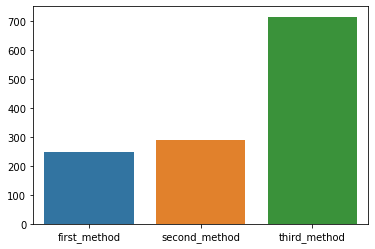

In [146]:
sns.barplot(x=nome,y=[tempo1,tempo2,tempo3])

## What is the most optimal algorithm, in your opinion, and why?

The best method is the first: the time complexity that we have calculated it's the same but in the first case we have considered the worst case. If we consider the case in which the list is already sorted the time complexity reduces to $O(k)$, while with the other methods it remains at $O(k^2)$.

## Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the ApplicantsInfo.txt file.

In [43]:
import numpy as np
import time

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
app = sc.textFile('s3://paolo2022bucket/ApplicantsInfo.txt')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
appsplit = app.filter(lambda x: x != '50000 1000').map(lambda ite: ite.split())  # delete the first item, split each item                     

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
def media(x): # trasform each 'number' in int, take the average, round to the second decimal
    y=round(np.mean([int(x[i]) for i in range(len(x))]),2)
    return y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# build the tuple (mean, name), groupBy mean
# sort the means
# sort the names in alphabetical order
medie = appsplit.map(lambda x: (media(x[2:]),' '.join(x[:2]))).groupByKey().sortBy(lambda x: x[0], ascending = False).map(lambda x: (x[0],sorted(x[1])))  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
medie.take(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(24.49, ['Emily Crispin', 'Patricia Witten']), (24.45, ['Doreen Richmond']), (24.44, ['Bruce Johnson', 'David Niederberger', 'Keisha Keene', 'Steven Boston']), (24.42, ['John Johnson', 'Marvin Ramirez', 'Melody Sanchez']), (24.41, ['Edith Lehtonen', 'Ida Mccabe', 'Joshua Reece', 'Luisa Young', 'Manuel Sullinger'])]

In [36]:
def spezza(x):  # split (mean, list(name_1,...,name_k)) to [(mean, name_1),...,(mean,name_k)]
    return [(x[0],i) for i in x[1]]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
end = medie.map(lambda x: spezza(x)).reduce(lambda a,b: a+b) # apply spezza to each item and merge the lists

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
for i in end:
    print(i)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(24.49, 'Emily Crispin')
(24.49, 'Patricia Witten')
(24.45, 'Doreen Richmond')
(24.44, 'Bruce Johnson')
(24.44, 'David Niederberger')
(24.44, 'Keisha Keene')
(24.44, 'Steven Boston')
(24.42, 'John Johnson')
(24.42, 'Marvin Ramirez')
(24.42, 'Melody Sanchez')
(24.41, 'Edith Lehtonen')
(24.41, 'Ida Mccabe')
(24.41, 'Joshua Reece')
(24.41, 'Luisa Young')
(24.41, 'Manuel Sullinger')
(24.4, 'Betty Kubiak')
(24.4, 'Cara Baird')
(24.4, 'Kelsey Mcneill')
(24.4, 'Mattie Salinas')
(24.4, 'Particia Mirabal')
(24.4, 'Richard Parker')
(24.4, 'Violet Paulino')
(24.39, 'Amy Walker')
(24.39, 'Harry Lupu')
(24.39, 'Jeffrey Johnson')
(24.39, 'Kathleen Whaley')
(24.39, 'Latoya Stemp')
(24.39, 'Marie Wall')
(24.38, 'Amanda Williams')
(24.38, 'Daryl Singer')
(24.38, 'David Kerns')
(24.38, 'Desiree Paul')
(24.38, 'Jackson Klopfer')
(24.38, 'Jeramy Galicia')
(24.38, 'Josephine Young')
(24.38, 'Juan Gonzalez')
(24.38, 'Kyle Carlson')
(24.38, 'Mary Nguyen')
(24.38, 'Norma Smith')
(24.38, 'Olive Sacco')
(24.38,

In [44]:
inizio = time.time()
app = sc.textFile('s3://paolo2022bucket/ApplicantsInfo.txt')
appsplit = app.filter(lambda x: x != '50000 1000').map(lambda ite: ite.split())
medie = appsplit.map(lambda x: (media(x[2:]),' '.join(x[:2]))).groupByKey().sortBy(lambda x: x[0], ascending = False).map(lambda x: (x[0],sorted(x[1])))  
end = medie.map(lambda x: spezza(x)).reduce(lambda a,b: a+b)
fine = time.time()
fine-inizio

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10.462803840637207

<AxesSubplot:>

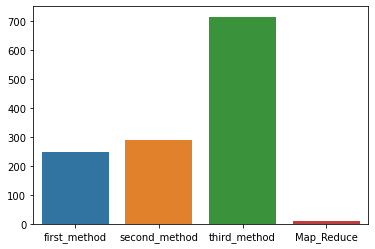

In [148]:
nome=['first_method','second_method','third_method','Map_Reduce']
sns.barplot(x=nome,y=[tempo1,tempo2,tempo3,fine-inizio])

The MapReduce algorithm is more efficient then the three algorithms.